# 1  Mod 4 Project: Natural Language Processing (NLP) -  Working Copy

### Improving online conversation: Use of NLP analysis to build a multi-headed model capable of detecting different types of online discussion toxicity like threats, obscenity, insults, and identity-based hate.



   Student name: Andi Osika  
 * Student pace: part time
 * Scheduled project review date/time: June 30, 2020
 * Instructor name: James Irving, PhD
 * Blog post URL: tbd

## Project Quick Links:
**Link** | **Description**
--| --|
[Background](#Background:) | Details around the subject, datasource and objective
[Preprocessing](#Preprocessing:) | Steps taken to prepare data for modeling and evaluation
[Main Dataset](#Main-Dataset:) | The dataset in it's final form used for the predictive modeling results described in the [Conclusion](#Conclusion:)  section
[Modeling](#Modeling:) | Various iterations of predictive classification modeling including Decision Trees, Random Forest and XGBoost
[Best Model](#BEST-MODEL:-Manually-Tuned-Random-Forest) |Random Forest Classification Model including [Visualizations]() Confusion Matrix, ROC Curve, Feature Importance by Rank, Correlations
    [Conclusion](#Conclusion:) | Summation of outcomes from modeling

## Background:

Freedom of speech is a right.  Digital platforms facilitate conversations, but struggle to do so efficiently while enabling this freedom while minimizing abuse and harrasment that can come with the 'anonymity effect' of a virtual climate.  

Even though the Constitution guarantees the right of free speech, that right is not an absolute one. The law has long recognized specific limitations when it comes to speech, such as prohibitions against slander and libel. 

This dataset is provided by [Conversation AI ](https://conversationai.github.io/) is a collaborative research effort exploring ML as a tool for better discussions online.  The source is a collection of comments from Wikipedia’s talk page edits circa 2017.  The result is a classification list of 159,571 samples provided by Wikipedia and have been labeled by human raters for toxic effects.  These comment classifications can fall into more than one of the following categories:

>The types of toxicity are:
* toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate


**Warning:** the text found in each of the categories outlined above is extremely offensive.  The supporting visualizations are equally offensive.  Because of this, edited versions of some the most offensive findings were/are edited text that I feel conveys the ideas without perpetuating the toxic messages and used for the non-technical explanation.  However the findings in this analysis are necessary for identification's sake.  The intention is to use this type of analysis in order to mitigate situations where others feel unable to share their views at the risk of abuse or feeling that are in harm's way.

In [257]:
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

### Data Import: Trainging and Testing DataSets

#### Test - DID NOT USE THE TESTING DATASET PROVIDED.. INSTEAD SPLIT THE TRAINING DATA TO MAKE THE OVERALL DATASET SMALLER DUE TO THE COMPUTATIONAL EXPENSE CAUSED BY LARGER DATASETS

In [2]:
test = pd.read_csv('test.csv', index_col='id')
test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [3]:
X_test = test['comment_text']

In [4]:
y_test = pd.read_csv('test_labels.csv', index_col='id')

In [5]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [6]:
y_test = y_test[y_test.sum(axis=1)!=-6]
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0001ea8717f6de06,0,0,0,0,0,0
000247e83dcc1211,0,0,0,0,0,0
0002f87b16116a7f,0,0,0,0,0,0
0003e1cccfd5a40a,0,0,0,0,0,0
00059ace3e3e9a53,0,0,0,0,0,0


In [7]:
val_counts_test = y_test.apply(pd.Series.value_counts)
val_counts_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,57888,63611,60287,63767,60551,63266
1,6090,367,3691,211,3427,712


In [8]:
val_counts_test.head(2).plot(kind='bar',figsize=(10,8))

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/55975

#### Train Test Split

In [9]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
X = train['comment_text']

In [11]:
target_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[target_classes]

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,108232,118498,113343,119310,113776,118634
1,11446,1180,6335,368,5902,1044


In [15]:
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000
mean,0.095640,0.009860,0.052934,0.003075,0.049316,0.008723
std,0.294098,0.098806,0.223902,0.055367,0.216527,0.092991
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# check for any 'null' comment
no_comment = X_train.isnull().value_counts()
len(no_comment)

1

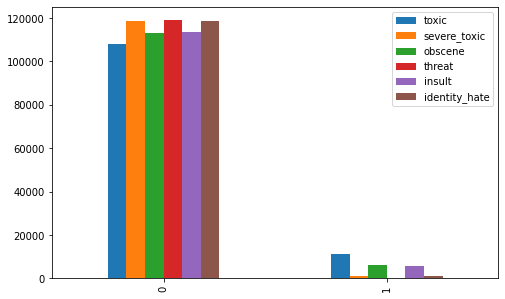

In [17]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts.head(2).plot(kind='bar',figsize=(8,5))

In [18]:
##develop the viz above to illustrate

In [19]:
value_counts_train = round(val_counts.head(2).T)
value_counts_train

,0,1
toxic,108232,11446
severe_toxic,118498,1180
obscene,113343,6335
threat,119310,368
insult,113776,5902
identity_hate,118634,1044


In [20]:
unlabelled_in_all = y_train[(y_train['toxic']!=1) & (y_train['severe_toxic']!=1) & (y_train['obscene']!=1) & 
                            (y_train['threat']!=1) & (y_train['insult']!=1) & (y_train['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', round(len(unlabelled_in_all)/len(train)*100))

Percentage of unlabelled comments is  67


In [21]:
#Total rows in train
print('Total rows in X_train is {}'.format(len(X_train)))

Total rows in X_train is 119678


In [ ]:
toxic_classes = y_train[y_train[target_classes].sum(axis=1)>0]


In [270]:
toxic_classes

,toxic,severe_toxic,obscene,threat,insult,identity_hate
66613,1,0,0,0,0,0
156118,1,0,0,0,0,0
111276,1,1,1,0,1,0
22021,1,0,1,0,1,1
4507,1,0,0,0,1,0
...,...,...,...,...,...,...
80163,1,0,0,0,0,0
113183,1,0,1,0,1,0
71557,1,1,1,0,1,0
49866,1,0,0,1,0,0


You can see here that some labels can be assigned to more than one class

In [273]:
toxic_classes['toxic'].sum()/len(toxic_classes)

0.9443115254516954

.... but not all comments tagged are necessarily 'toxic', but most of them are... 94%

#### Frequency Distributions:

An initial look will examine frequency distributions

In [23]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# It is generally a good idea to also remove punctuation

# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

In [24]:
text = str(list(X_train))

### Tokenizing initial set of text corpus to develop stopword list:
(Takes 2 Min)

In [25]:
import functions as fn

2020-06-18 16:03:36.443751-07:00
[i] Timer started at06/18/20 - 04:03 PM
[i] Timer ended at 06/18/20 - 04:03 PM
- Total time = 0:00:00


In [26]:
timer = fn.Timer()

timer.start()
tokens = word_tokenize(text)
timer.stop()

[i] Timer started at06/18/20 - 04:03 PM
[i] Timer ended at 06/18/20 - 04:05 PM
- Total time = 0:01:47.292164


In [27]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

#remove punctuation
stopwords_list += list(string.punctuation)
##adding adhoc all strings that don't appear to contribute, added 'article, page and wikipedia' iteratively as 
##these are parts of most comment strings
stopwords_list += ("''","``", "'s", "\\n\\n" , '...', 'i\\','\\n',
                   '•', "i", 'the', "'m", 'i\\', "'ve", "don\\'t",
                  "'re", "\\n\\ni", "it\\", "'ll", 'you\\', "'d", "n't",
                  '’', 'article', 'page', 'wikipedia') 

In [28]:
timer = fn.Timer()
timer.start()
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopwords_list]
timer.stop()

[i] Timer started at06/18/20 - 04:05 PM
[i] Timer ended at 06/18/20 - 04:05 PM
- Total time = 0:00:25.983603


In [29]:
len(stopped_tokens)

4118759

In [30]:
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_output =[lemmatizer.lemmatize(w) for w in stopped_tokens]

In [31]:
len(lemmatized_output)

4118759

In [32]:
from nltk import FreqDist
freqdist = FreqDist(stopped_tokens)
most_common_stopped = freqdist.most_common(200)
most_common_stopped

[('talk', 25572),
 ('would', 22158),
 ('one', 20752),
 ('like', 20746),
 ('please', 18599),
 ('see', 15627),
 ('think', 14878),
 ('also', 14551),
 ('know', 14465),
 ('people', 13333),
 ('edit', 13016),
 ('use', 11984),
 ('articles', 11893),
 ('may', 11494),
 ('time', 11403),
 ('get', 9940),
 ('even', 9930),
 ('make', 9641),
 ('user', 9159),
 ('could', 8960),
 ('good', 8954),
 ('information', 8873),
 ('want', 8710),
 ('way', 8296),
 ('sources', 8044),
 ('deletion', 7963),
 ('name', 7841),
 ('new', 7744),
 ('first', 7710),
 ('need', 7657),
 ('wp', 7569),
 ('say', 7548),
 ('well', 7497),
 ('source', 7476),
 ('editing', 7465),
 ('help', 7379),
 ('image', 7350),
 ('pages', 7302),
 ('section', 7286),
 ('edits', 7274),
 ('go', 7246),
 ('thanks', 7135),
 ('made', 7100),
 ('much', 7013),
 ('many', 6929),
 ('fuck', 6903),
 ('really', 6818),
 ('used', 6756),
 ('find', 6713),
 ('discussion', 6599),
 ('work', 6458),
 ('deleted', 6451),
 ('point', 6257),
 ('add', 6120),
 ('since', 6098),
 ('right', 

In [33]:
feq_vals = freqdist.values

In [34]:
print(feq_vals)

<built-in method values of FreqDist object at 0x000002470AC1DEB8>


In [35]:
freqdistlem = FreqDist(lemmatized_output)
most_common_lem = freqdistlem.most_common(200)

In [36]:
most_common_lem

[('talk', 25781),
 ('would', 22158),
 ('one', 21882),
 ('like', 21073),
 ('please', 18599),
 ('see', 15781),
 ('source', 15520),
 ('think', 15409),
 ('know', 15207),
 ('also', 14551),
 ('time', 13848),
 ('people', 13664),
 ('edit', 13016),
 ('make', 12063),
 ('use', 11984),
 ('article', 11893),
 ('user', 11833),
 ('may', 11498),
 ('get', 10876),
 ('say', 10701),
 ('need', 10330),
 ('image', 10034),
 ('even', 9931),
 ('link', 9635),
 ('want', 9546),
 ('name', 9474),
 ('good', 8994),
 ('could', 8960),
 ('way', 8940),
 ('information', 8917),
 ('editor', 8369),
 ('go', 8337),
 ('comment', 8321),
 ('section', 8308),
 ('thing', 8271),
 ('deletion', 8192),
 ('question', 7945),
 ('fact', 7926),
 ('help', 7809),
 ('new', 7744),
 ('first', 7715),
 ('work', 7586),
 ('wp', 7569),
 ('point', 7565),
 ('well', 7562),
 ('look', 7549),
 ('editing', 7477),
 ('discussion', 7340),
 ('page', 7302),
 ('edits', 7274),
 ('u', 7165),
 ('thanks', 7136),
 ('made', 7100),
 ('right', 7054),
 ('much', 7014),
 ('fuc

Lemmatizing gave no different result

In [37]:
X_train.head()

143075    Please do not add unsourced or original conten...
65320     This page needs a new update of the UMW seal. ...
64545     "\n\nOh, so sad! Why you always remind of me? ...
58827     Brother==\nWhy isn't his brother David mention...
6536      Biographies\nHello Sparky331, and welcome to W...
Name: comment_text, dtype: object

### EDA: Looking Deeper at the classes:

In [38]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [39]:
df = train.copy()

In [40]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [42]:
x=df.iloc[:,2:].sum()
display(x)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [43]:
import matplotlib.pyplot as plt

### Visual: Topys of Toxic Comments by Occurence

Text(0.5, 0, 'Category of Toxic Text')

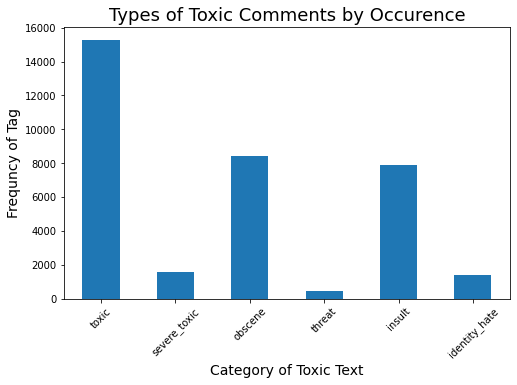

In [44]:

x.plot(kind='bar', figsize=(8,5))
plt.xticks(rotation=45)
plt.title('Types of Toxic Comments by Occurence',fontsize=18 )
plt.ylabel('Frequncy of Tag', fontsize=14)
plt.xlabel('Category of Toxic Text', fontsize=14)

Toxic is by far the highest occurance, and threats are significantly lower.

### Examples of Varrying Toxic Text and The Correlations:

In [45]:
#!pip install simple_colors

In [46]:
 from simple_colors import *

In [47]:
print(blue("Example of toxic text:",['bold']))
print(train[train['toxic']==1].iloc[2,1])
print('-----------------------------')
print(blue("Example of severe toxic text:",['bold']))
print(train[train['severe_toxic']==1].iloc[3,1])
print('-----------------------------')
print(blue("Example of obscene text:",['bold']))
print(train[train['obscene']==1].iloc[4,1])
print('-----------------------------')
print(blue("Example of threatening text:",['bold']))
print(train[train['threat']==1].iloc[2,1])
print('-----------------------------')
print(blue("Example of insulting text:",['bold']))
print(train[train['insult']==1].iloc[3,1])
print('-----------------------------')
print(blue("Example of identity hate based text:",['bold']))
print(train[train['identity_hate']==1].iloc[39,1])

Example of toxic text:
Bye! 

Don't look, come or think of comming back! Tosser.
-----------------------------
Example of severe toxic text:
Hi 

Im a fucking bitch.

50.180.208.181
-----------------------------
Example of obscene text:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
-----------------------------
Example of threatening text:
I'm also a sock puppet of this account...SUPRISE!!
-sincerely,
            The man that will track you down from the Internet and kill you
-----------------------------
Example of insulting text:
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
-----------------------------
Example of identity hate based text:
terrorist 

You seem like a terrorist sir. Are you penises as small as they say they are? I have corroborated it with a cite something you never bothered to do. You may keep your comments about drones as long as you cite it even though it has no place on this p

In [48]:
import seaborn as sns

### Visual: Correlations between varying forms of toxicity:

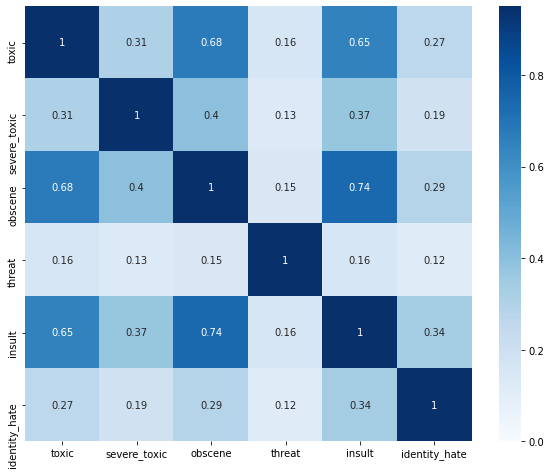

In [49]:
corr=y_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="Blues", mask=mask, vmin=0, vmax=.95,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [50]:
#getting the totals from each row to identify if they had any toxic comments or not
rowtotals = train.iloc[:,2:].sum(axis=1)
df['clean_text'] = (rowtotals==0)
df['toxic_text'] = (rowtotals!=0)

In [51]:
print("Number of clean comments:", df['clean_text'].sum())
print("Number of toxic comments:", df['toxic_text'].sum())
print("Percentage of toxic comments in sample", (df['toxic_text'].sum()/
                                                      (df['clean_text'].sum() +
                                                       df['toxic_text'].sum()))*100)

Number of clean comments: 143346
Number of toxic comments: 16225
Percentage of toxic comments in sample 10.167887648758233


In [52]:
df['wrd_count'] = df['comment_text'].str.count(' ') + 1


### Visual: Toxic Comment Frequency

Text(0.5, 0, 'Toxic Comments')

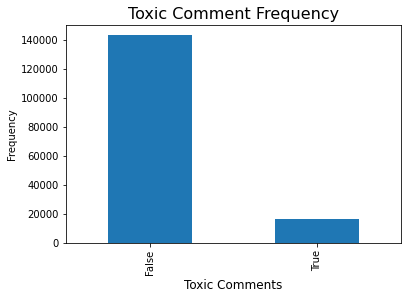

In [53]:
df['toxic_text'].value_counts().plot(kind='bar')
plt.title('Toxic Comment Frequency',fontsize=16)
plt.ylabel('Frequency')
plt.xlabel("Toxic Comments", fontsize=12)

In [54]:
tox_text_df = df.loc[df['toxic_text']==1]
clean_text_df = df.loc[df['clean_text']==1]


Looking to see if ID has some sort of meaning... e.g. user id each value is unique

In [55]:
sorted(tox_text_df['id'].value_counts(), reverse=True)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [56]:
#separate the strings to set up for counting unique numbers:
tox_unique = set()
tox_text_df['text'] = tox_text_df['comment_text'].str.lower().str.split().apply(tox_unique.update)
clean_unique = set()
clean_text_df['text'] = clean_text_df['comment_text'].str.lower().str.split().apply(clean_unique.update)

C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [57]:
print(f'Number of unique words in toxic corpus',len(tox_unique))
print(f'Number of unique words in clean corpus', len(clean_unique))

Number of unique words in toxic corpus 66619
Number of unique words in clean corpus 445710


Since there are far less toxic words, it makes sense there are fewer unique words in the toxic corpus.

In [58]:
df.iloc[6]

id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
clean_text                                              False
toxic_text                                               True
wrd_count                                                   8
Name: 6, dtype: object

### Visual: Word Cound Comparison Toxic vs NonToxic

In [59]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

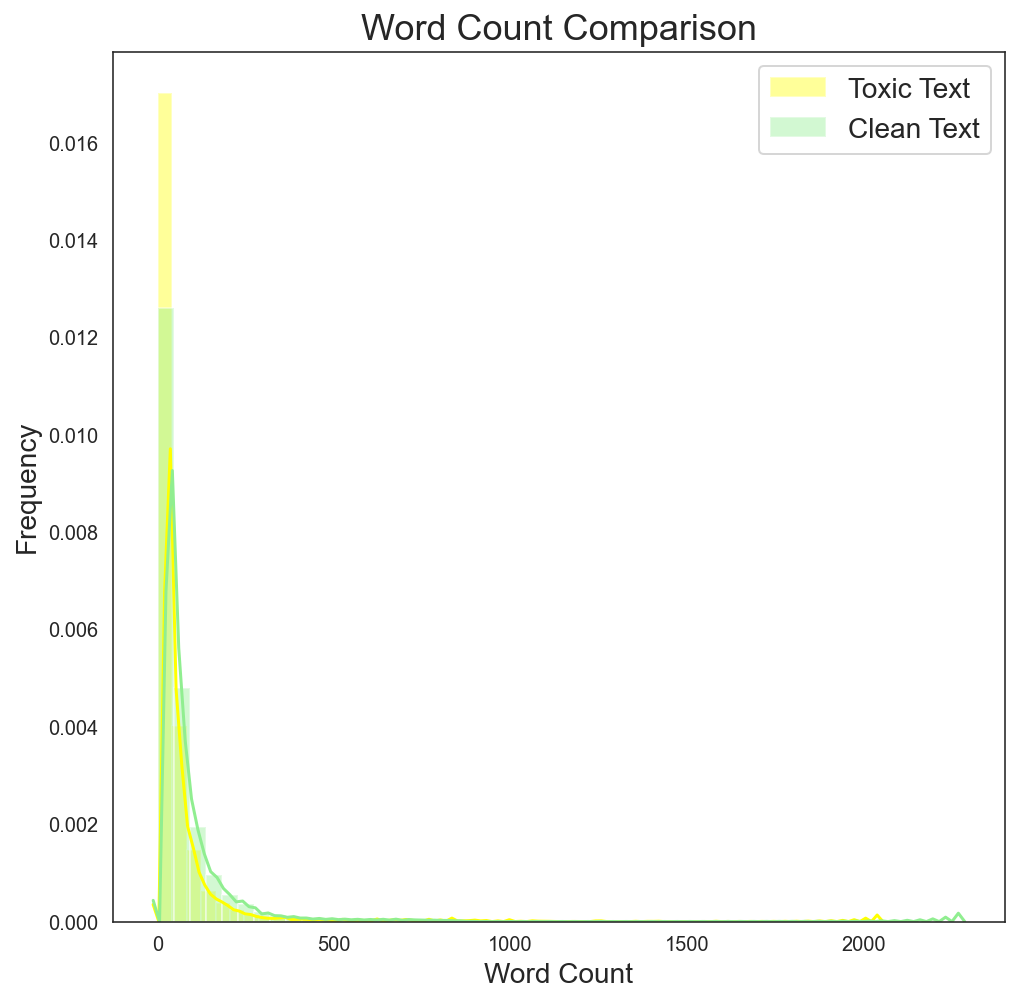

In [60]:
plt.figure(figsize=(8,8))
sns.distplot(tox_text_df['wrd_count'], color='yellow', label='Toxic Text')
sns.distplot(clean_text_df['wrd_count'],color='lightgreen', label='Clean Text')
plt.title('Word Count Comparison', fontsize = 18)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Word Count', fontsize=14)
plt.legend(fontsize=14)

Observation: at a high level, there's not much difference comparatively in terms of word count between toxic and non toxic comments:

In [61]:
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,toxic_text,wrd_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,False,42
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,False,18


In [62]:
# creating separate dataframes for each type of toxicity for possible analysis
ToxicDf = df[(df['toxic'] == 1)]
SevTox = df[(df['severe_toxic'] == 1)]
Obs = df[(df['obscene'] == 1)]
Threat = df[(df['threat'] == 1)]
Inst = df[(df['insult'] == 1)]
IDH8 = df[(df['identity_hate']==1)]        

In [63]:
#since toxic was highly correlated with obscene, looking into frequency:
tox_obs = df[(df['toxic'] ==1) & (df['obscene'])]
len(tox_obs)

7926

In [64]:
print("Comments tagged as toxic:", (len(ToxicDf)))
print("Comments tagged as obscene:", (len(Obs)))
print("Comments tagged as toxic and obscene", len(tox_obs))
print("Percentage of comments tagged as toxic and obscene" )
print("compared to soley toxic", (round(len(tox_obs)/len(Obs),2)*100))

Comments tagged as toxic: 15294
Comments tagged as obscene: 8449
Comments tagged as toxic and obscene 7926
Percentage of comments tagged as toxic and obscene
compared to soley toxic 94.0


In [65]:
#Text specficially classified for each class
toxic_text = str(list(ToxicDf['comment_text']))
sev_toxic_text = str(list(SevTox['comment_text']))
obs_text = str(list(Obs['comment_text']))
threat_text = str(list(Threat['comment_text']))
insult_text = str(list(Inst['comment_text']))
idh8_text = str(list(IDH8['comment_text']))


In [274]:
type(threat_text)

str

In [278]:
from importlib import reload

In [291]:
reload(fn)

2020-06-22 13:57:29.784102-07:00
[i] Timer started at06/22/20 - 01:57 PM
[i] Timer ended at 06/22/20 - 01:57 PM
- Total time = 0:00:00.000997


<module 'functions' from 'C:\\Users\\aosika\\flatiron-ds-course\\Mod_4\\dsc-mod-4-project-v2-1-online-ds-pt-100719\\functions.py'>

### Varying Classes of Toxic Text:

Warning: the hidden cells contain extremely toxic text that was collected in the samples.



##### Toxic:

In [285]:
tox_toks = fn.tok_text(toxic_text)

In [89]:
type(tox_toks)

list

In [286]:
freq_tox = fn.freq_dist(tox_toks)
dict(freq_tox)

{'fuck': 8316,
 'like': 3458,
 'shit': 3282,
 'nigger': 3243,
 'suck': 3136,
 'fucking': 3118,
 'ass': 2856,
 'hate': 2600,
 'u': 2587,
 'go': 2546,
 'know': 2177,
 'get': 2147,
 'gay': 2070,
 'fat': 1953,
 'faggot': 1908,
 'die': 1870,
 'moron': 1843,
 'people': 1808,
 'bitch': 1668,
 'hi': 1544,
 'one': 1440,
 'cunt': 1435,
 'stupid': 1383,
 'pig': 1344,
 'jew': 1327,
 'talk': 1319,
 'think': 1224,
 'want': 1208,
 'sucks': 1194,
 'stop': 1149,
 'wiki': 1132,
 'dick': 1098,
 'would': 1080,
 'block': 1049,
 'wanker': 1019,
 'time': 1007,
 'life': 1005,
 'bark': 1000,
 'even': 992,
 'balls': 987,
 'fag': 986,
 'dont': 974,
 'going': 946,
 'sex': 928,
 'make': 923,
 'cock': 906,
 'edit': 898,
 'vandalism': 898,
 'right': 897,
 'see': 872,
 'little': 842,
 'piece': 841,
 'user': 822,
 'nipple': 822,
 'asshole': 804,
 'really': 797,
 'penis': 797,
 'kill': 788,
 'aids': 779,
 'hell': 767,
 'dickhead': 750,
 'good': 749,
 "'fuck": 732,
 'fucker': 730,
 'care': 727,
 'say': 725,
 'bastard': 

In [73]:
freq_tox_list = clean_up(freq_tox)

Text(0.5, 0, 'frequency')

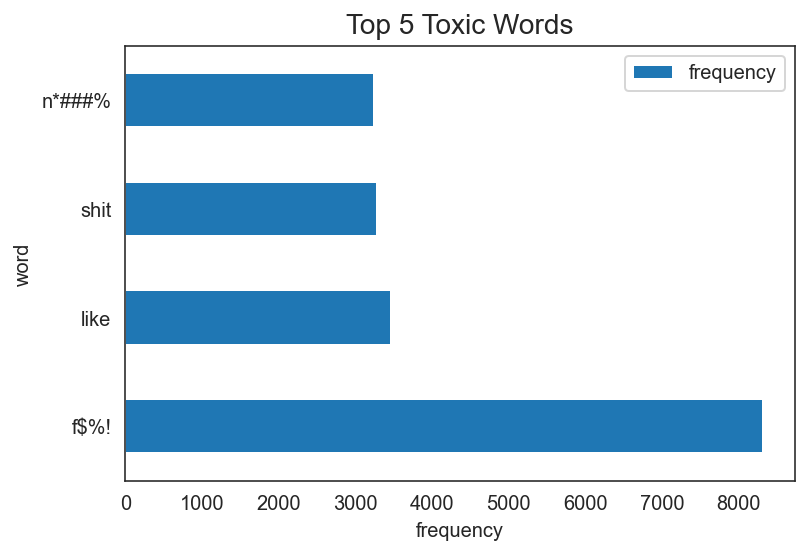

In [74]:
freq_toxic_df = pd.DataFrame(freq_tox_list, columns=['word', 'frequency'])
freq_tox_top_5 = freq_toxic_df[0:4]
freq_tox_top_5

freq_tox_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Toxic Words', fontsize=14)
plt.xlabel('frequency')

##### Common toxic word cloud is extrememly offensive - measures were taken to edit for the sake of observing without perpetuating

In [75]:
#wordcloud.generate_from_frequencies(',')

In [76]:
def clean_up(freq_tox): 
    
    
    ## creating a dictionary of the most offensive words
    replace = {'fuck': 'f$%!', 'nigger' : "n*###%" ,'nigga':'n#5#*', 'fucking' : 'f*@%!ng',
               'faggot':'f@&&*#', 'cunt' : 'c&#^' , 'fag' : 'f@$',
               "'fuck" : "'f$%!'", 'faggots':'f@&&*!$'}

    #using the 'replace' dictionary above, 

    new_dict = {}
    for k, v in dict(freq_tox).items():
        if k in replace:
            key = replace[k]
        else:
            key = k

        new_dict[key] = v
        
    cleaned_list = [ [k,v] for k, v in new_dict.items() ]
    
    return cleaned_list

In [115]:
##creating a dictionary of primary offensive words to clean up a visual.  These are highly offensive and
##I am completely uncomfortable even typing them for this purpose, but needs to be done.
dic = {'fuck': 'fword', 'nigger' : "nword" , 'nigga':'nwordderivatie','fucking' : 'fwordderivative',
               'faggot':'fwordforgay', 'cunt' : 'cword' ,'cunts' : 'cwords', 'shit': 'shword', 'fag' : 'shortenedfwordforgay',
               "'fuck" : "'fword'", 'faggots':'fwordforgays'}

In [116]:
def replace_all(lst, dic):
    new_lst = []
    for st in lst:
        for i, j in dic.items():
            st = st.replace(i, j)
            new_lst.append(st)
    return new_lst

In [112]:
#tox_toks

In [117]:
clean_tox_toks = replace_all(tox_toks, dic )


Due to the nature and severity of the language, one word cloud will be used to demonstrate common words in the toxic classivication:

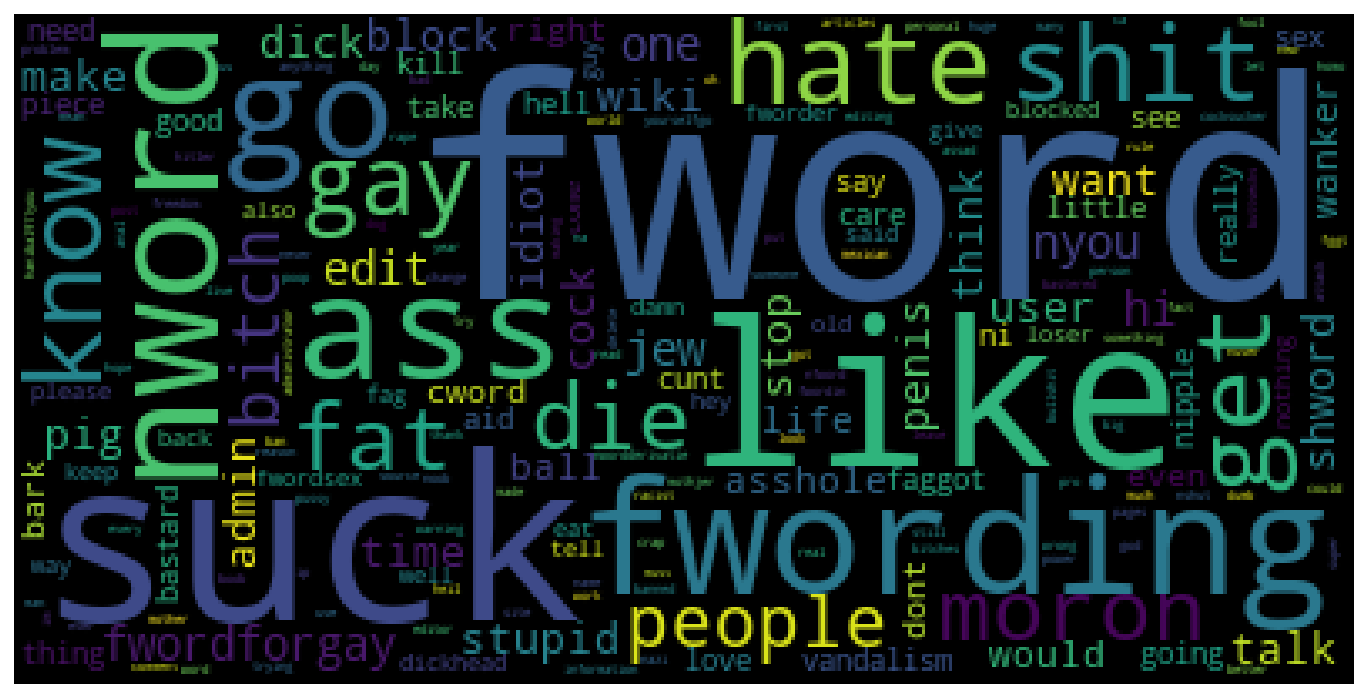

In [292]:
fn.wrd_cld(clean_tox_toks)


##### Severe Toxic

In [120]:
sev_tox_toks = fn.tok_text(sev_toxic_text)

In [121]:
freq_sev_tox = fn.freq_dist(sev_tox_toks)
freq_sev_tox

[('fuck', 6163),
 ('suck', 2486),
 ('ass', 2100),
 ('shit', 1864),
 ('faggot', 1491),
 ('u', 1437),
 ('fucking', 1334),
 ('go', 1157),
 ('bitch', 1057),
 ('nigger', 977),
 ('die', 961),
 ('cunt', 784),
 ('sucks', 730),
 ('cock', 675),
 ('fucksex', 624),
 ('yourselfgo', 621),
 ('fucker', 584),
 ('kill', 577),
 ("'fuck", 517),
 ('cocksucker', 507),
 ('piece', 501),
 ('mothjer', 489),
 ('dick', 483),
 ('gay', 468),
 ('bastard', 448),
 ('huge', 423),
 ('fat', 406),
 ('damn', 396),
 ('rape', 382),
 ('dog', 373),
 ('offfuck', 360),
 ('stupid', 358),
 ('mexicans', 355),
 ('pro-assad.hanibal911you', 345),
 ('\\nshut', 343),
 ('like', 339),
 ('niggas', 337),
 ('dickhead', 333),
 ('bitches.fuck', 333),
 ('pussy', 329),
 ('asshole', 328),
 ('anal', 316),
 ('block', 314),
 ('eat', 312),
 ('get', 310),
 ('criminalwar', 279),
 ('bunksteve', 277),
 ('going', 273),
 ('cocksucking', 272),
 ('chester', 261),
 ('marcolfuck', 260),
 ('want', 257),
 ('penis/////small', 249),
 ('cocks', 232),
 ('useless', 2

In [293]:
freq_sevtox_list = fn.clean_up(freq_sev_tox)

In [123]:
freq_sevtoxic_df = pd.DataFrame(freq_sevtox_list, columns=['word', 'frequency'])
freq_sevtox_top_5 = freq_sevtoxic_df[0:4]
freq_sevtox_top_5

,word,frequency
0,f$%!,6163
1,suck,2486
2,ass,2100
3,shit,1864


Text(0.5, 0, 'frequency')

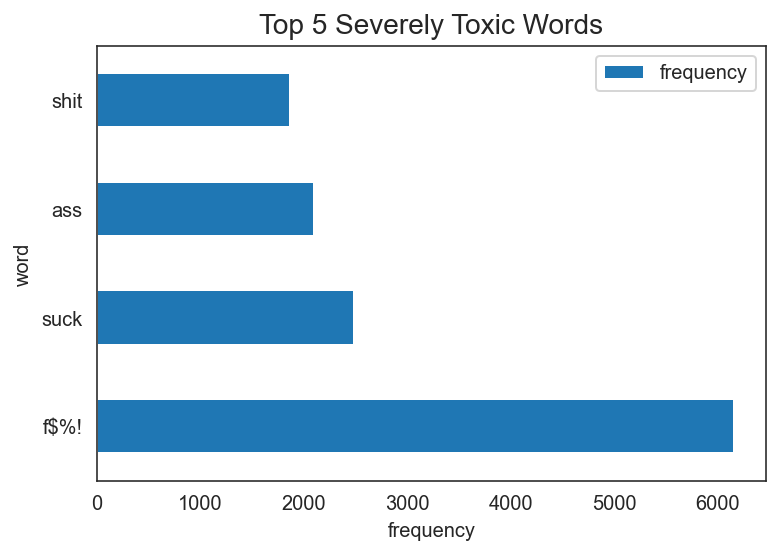

In [124]:
freq_sevtox_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Severely Toxic Words', fontsize=14)
plt.xlabel('frequency')

##### Obscene

In [125]:
obs_toks = fn.tok_text(obs_text)

In [126]:
obs_tox = fn.freq_dist(obs_toks)

In [127]:
obs_tox_list = fn.clean_up(obs_tox)

Text(0.5, 0, 'frequency')

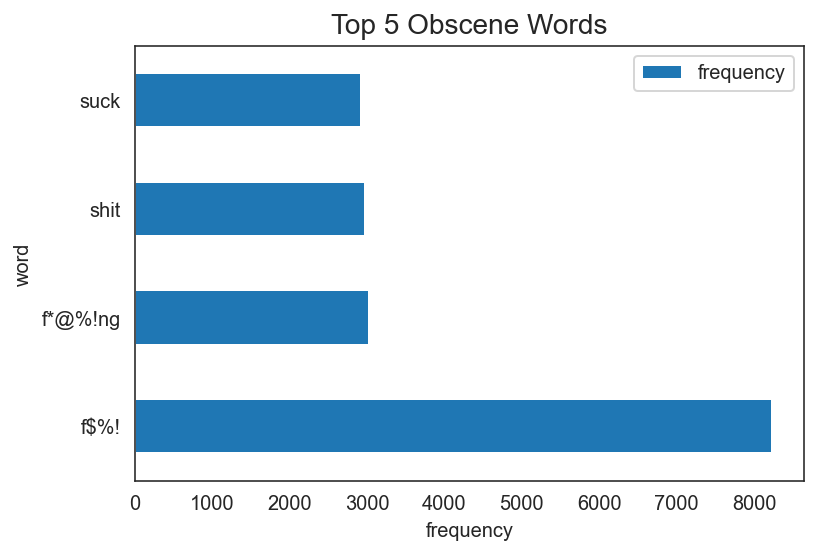

In [128]:
freq_obs_df = pd.DataFrame(obs_tox_list, columns=['word', 'frequency'])
freq_obs_top_5 = freq_obs_df[0:4]
freq_obs_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Obscene Words', fontsize=14)
plt.xlabel('frequency')

##### Threat

In [129]:
threat_toks = fn.tok_text(threat_text)

In [130]:
threat_tox = fn.freq_dist(threat_toks)

In [131]:
freq_threat_list = fn.clean_up(threat_tox)

Text(0.5, 0, 'frequency')

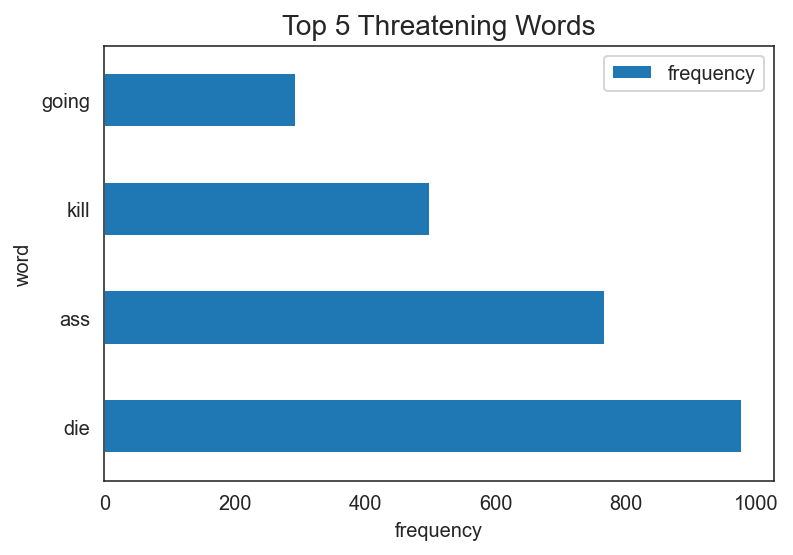

In [132]:
freq_threat_df = pd.DataFrame(freq_threat_list, columns=['word', 'frequency'])
freq_threat_top_5 = freq_threat_df[0:4]
freq_threat_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Threatening Words', fontsize=14)
plt.xlabel('frequency')

###### Insult

In [133]:
inslt_toks = tok_text(insult_text)

In [134]:
inslt_tox = freq_dist(inslt_toks)

In [135]:
inslt_tox_list = clean_up(inslt_tox)

Text(0.5, 0, 'frequency')

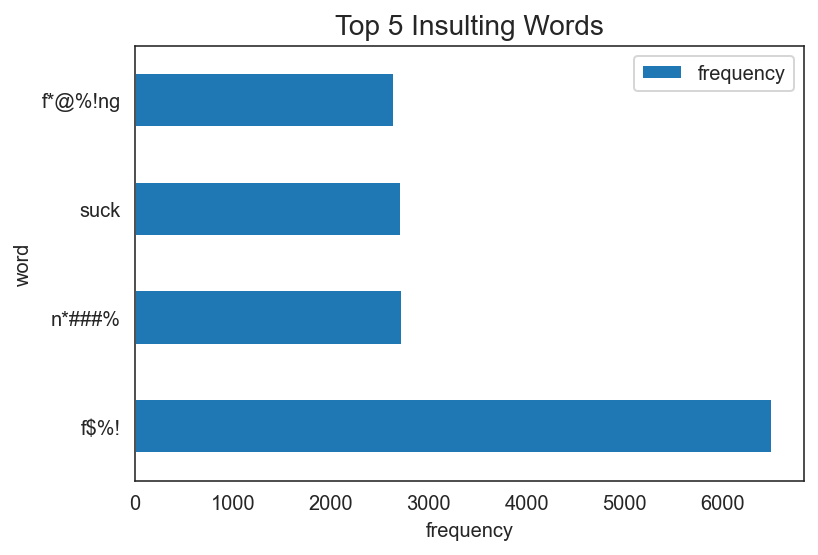

In [136]:
freq_insult_df = pd.DataFrame(inslt_tox_list, columns=['word', 'frequency'])
freq_insult_top_5 = freq_insult_df[0:4]
freq_insult_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Insulting Words', fontsize=14)
plt.xlabel('frequency')

##### Identity_hate

In [137]:
idh8_toks = fn.tok_text(idh8_text)

In [138]:
idh8_tox = fn.freq_dist(idh8_toks)
idh8_tox

[('nigger', 2919),
 ('fat', 1318),
 ('jew', 1302),
 ('gay', 887),
 ('fuck', 785),
 ('faggot', 726),
 ('die', 695),
 ('fucking', 502),
 ('huge', 428),
 ('suck', 419),
 ('shit', 401),
 ('stupid', 391),
 ('cunt', 391),
 ('like', 378),
 ('ass', 366),
 ('mexicans', 362),
 ('niggas', 341),
 ('bitch', 325),
 ('hate', 288),
 ('bunksteve', 277),
 ('go', 256),
 ('get', 233),
 ('tommy2010', 226),
 ('ancestryfuck-off-jewish', 207),
 ('u', 201),
 ('\\nyou', 197),
 ('kill', 196),
 ('licker', 181),
 ('spanish', 181),
 ('centraliststupid', 179),
 ('fan-1967', 176),
 ('jews', 174),
 ('people', 174),
 ('piece', 171),
 ('keep', 167),
 ('ca', 167),
 ('drink', 151),
 ('bleachanhero', 148),
 ('homo', 122),
 ('know', 115),
 ('niggers', 110),
 ('nigga\\n\\neat', 108),
 ('would', 105),
 ('think', 105),
 ('make', 103),
 ('utc', 102),
 ('nl33ers\\ni', 100),
 ('one', 99),
 ('little', 98),
 ('right', 96),
 ('want', 94),
 ('\\ncody', 92),
 ('di', 90),
 ('edie', 90),
 ('mitt', 89),
 ('romney', 89),
 ('stop', 86),
 (

In [139]:
freq_idh8_list = fn.clean_up(idh8_tox)

Text(0.5, 0, 'frequency')

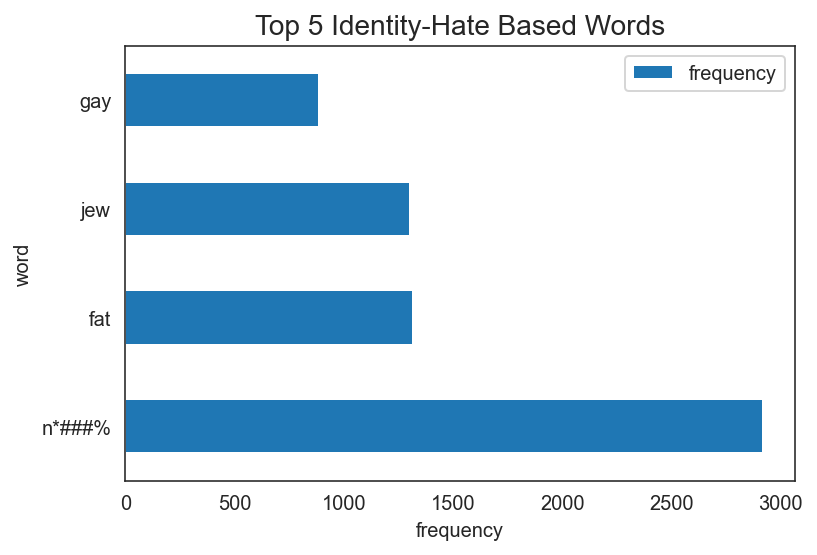

In [140]:
freq_idh8_df = pd.DataFrame(freq_idh8_list, columns=['word', 'frequency'])
freq_idh8_top_5 = freq_idh8_df[0:4]
freq_idh8_top_5.plot(kind='barh',x='word', y='frequency')
plt.title('Top 5 Identity-Hate Based Words', fontsize=14)
plt.xlabel('frequency')

## Modeling:

### Tokenizing

In [141]:
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#https://github.com/learn-co-students/dsc-classification-with-word-embeddings-codealong-online-ds-pt-100719
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [142]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
#try texts_to_matrix
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [143]:
comments = [len(comment) for comment in list_tokenized_train]

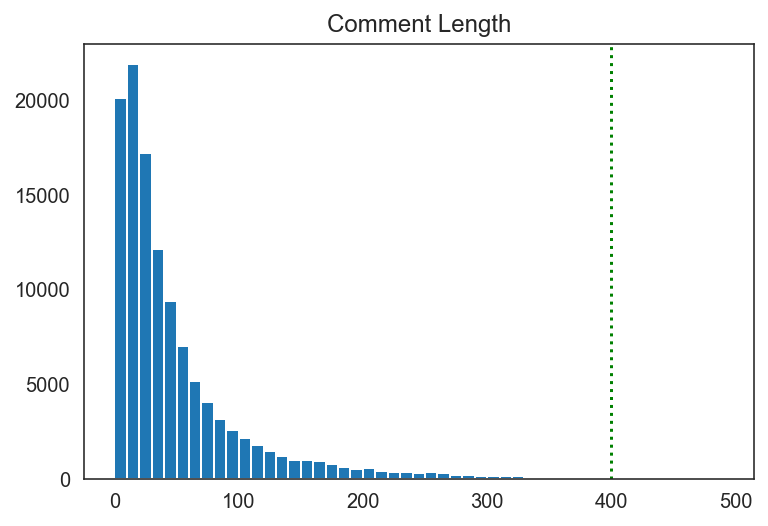

In [144]:
plt.hist(comments,bins = np.arange(0,500,10))
plt.axvline(x=400, color='g', ls=':')
plt.title('Comment Length')
plt.show()

In [267]:
#The majority distribution of comment length is ~0-30 words ... will capture everything with 400

## Main Dataset:

In [268]:
maxlen = 400
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [147]:
X_te.shape

(39893, 400)

In [148]:
X_t.shape[1]

400

In [149]:
type(X_t)

numpy.ndarray

### Vanilla Neural Network: Keras 

In [150]:
van_model = Sequential()

In [151]:
van_model.add(Dense(10, activation='relu', input_shape=(X_t.shape[1],) ))
van_model.add(Dense(6, activation='sigmoid'))

In [152]:
van_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [153]:
van_history = van_model.fit(X_t, y_train, epochs=10,
                            batch_size=200,
                            validation_split=.2)

Train on 95742 samples, validate on 23936 samples
Epoch 1/10
95742/95742 [==============================] - 1s 12us/step - loss: 0.5431 - accuracy: 0.9606 - val_loss: 0.2376 - val_accuracy: 0.9637
Epoch 2/10
95742/95742 [==============================] - 1s 10us/step - loss: 0.2062 - accuracy: 0.9625 - val_loss: 0.1951 - val_accuracy: 0.9637
Epoch 3/10
95742/95742 [==============================] - 1s 11us/step - loss: 0.1965 - accuracy: 0.9628 - val_loss: 0.1935 - val_accuracy: 0.9637
Epoch 4/10
95742/95742 [==============================] - 1s 10us/step - loss: 0.1903 - accuracy: 0.9628 - val_loss: 0.1941 - val_accuracy: 0.9637
Epoch 5/10
95742/95742 [==============================] - 1s 10us/step - loss: 0.1868 - accuracy: 0.9630 - val_loss: 0.2674 - val_accuracy: 0.9350
Epoch 6/10
95742/95742 [==============================] - 1s 11us/step - loss: 0.1839 - accuracy: 0.9630 - val_loss: 0.1926 - val_accuracy: 0.9637
Epoch 7/10
95742/95742 [==============================] - 1s 12us/st

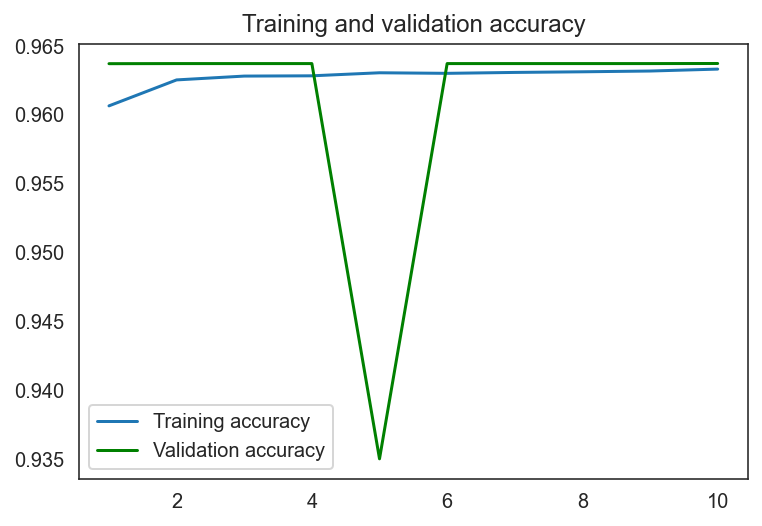

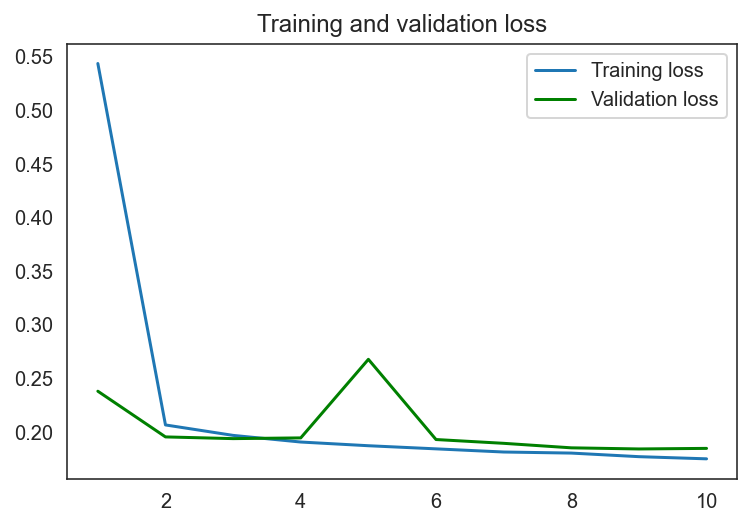

In [294]:
fn.plot_acc_loss(van_history)

In [155]:
def plot_loss_acc(history):
    import matplotlib.pyplot as plt
    %matplotlib inline 

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) +1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, color='g' , label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [156]:
y_h_van_probs = van_model.predict(X_te)

In [157]:
y_preds_van = pd.DataFrame(np.round(y_h_van_probs), columns=target_classes)

In [158]:
from sklearn.metrics import classification_report

In [333]:
reload(fn)

2020-06-23 17:02:37.766767-07:00
[i] Timer started at06/23/20 - 05:02 PM
[i] Timer ended at 06/23/20 - 05:02 PM
- Total time = 0:00:00.001156


<module 'functions' from 'C:\\Users\\aosika\\flatiron-ds-course\\Mod_4\\dsc-mod-4-project-v2-1-online-ds-pt-100719\\functions.py'>

In [334]:
van_rept = fn.class_report_model(y_train, y_test, y_preds_van)

identity_hate
[[1. 0.]
 [1. 0.]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39532
           1       0.00      0.00      0.00       361

    accuracy                           0.99     39893
   macro avg       0.50      0.50      0.50     39893
weighted avg       0.98      0.99      0.99     39893



In [315]:
print(van_rept)

None


In [332]:
def class_report_model(y_train,y_test, y_preds):
    '''creates a confusion matrix and classification model
    using training testing and predictions from a RNN classification model

    y_train - training data in tokenized form
    y_test - testing data in tokeinzed form
    y_preds - multinomial classification predictions in DataFrame form'''

    from sklearn.metrics import classification_report, confusion_matrix

    for i in range(0,y_train.shape[1]):
        y_i_hat_trnn = y_preds.iloc[:,i]
        y_tst = y_test.iloc[:,i]
        print(y_train.columns[i])
        print(confusion_matrix(y_tst, y_i_hat_trnn, normalize='true'))
        print()
        print(classification_report(y_tst, y_i_hat_trnn))

In [ ]:
class_report_model(y_train, y_test, y_preds_van)

In [313]:
for i in range(0,y_train.shape[1]):
    y_i_hat_van = y_preds_van.iloc[:,i]
    y_i = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i, y_i_hat_van))

toxic
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     36045
           1       0.00      0.00      0.00      3848

    accuracy                           0.90     39893
   macro avg       0.45      0.50      0.47     39893
weighted avg       0.82      0.90      0.86     39893

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39478
           1       0.50      0.00      0.00       415

    accuracy                           0.99     39893
   macro avg       0.74      0.50      0.50     39893
weighted avg       0.98      0.99      0.98     39893

obscene
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37779
           1       0.50      0.00      0.00      2114

    accuracy                           0.95     39893
   macro avg       0.72      0.50      0.49     39893
weighted avg       0.92      0.95      0.92    

#### Vanilla Neural Network Observations:

Initialized a very small and shallow 'vanilla' model to observe convergence trends and behavior.  Zero response from validation data and model overtrains by second epoch.  While accuracy is reported 90%+, recall is 0 in each category.

### RNN: LSTM_60_50_6

Implementing LSTM and dropout to see if there's improvement.:
**Run Time is 1 Hour 45 Min**

In [160]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers




In [161]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks, changing from 3-->2 since overfitting happens rapidly
early_stopping = [EarlyStopping(monitor='val_loss', patience=2), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [162]:
rnn = Sequential()
embedding_size = 128

rnn.add(Embedding(max_features, embedding_size, input_length=X_t.shape[1] ))
#adding LSTM layer to help 'forget' then pooling
rnn.add(LSTM(60, return_sequences=True, name='lstm_layer'))
rnn.add(GlobalMaxPool1D())
rnn.add(Dropout(0.1))  
rnn.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(.0001) ))
rnn.add(Dropout(0.1))
rnn.add(Dense(6, activation='sigmoid'))

In [163]:
rnn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [164]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 128)          256000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

In [165]:
## WARNING ⏰ 1 Hr 20 min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn.fit(X_t, y_train, epochs=20, 
                  callbacks=early_stopping,
                  batch_size=300, validation_split=0.33)
timer = timer.stop()

[i] Timer started at06/18/20 - 04:47 PM


C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 80184 samples, validate on 39494 samples
Epoch 1/20
80184/80184 [==============================] - 469s 6ms/step - loss: 0.2002 - accuracy: 0.9410 - val_loss: 0.1176 - val_accuracy: 0.9635
Epoch 2/20
80184/80184 [==============================] - 504s 6ms/step - loss: 0.0826 - accuracy: 0.9739 - val_loss: 0.0658 - val_accuracy: 0.9795
Epoch 3/20
80184/80184 [==============================] - 501s 6ms/step - loss: 0.0657 - accuracy: 0.9791 - val_loss: 0.0620 - val_accuracy: 0.9798
Epoch 4/20
80184/80184 [==============================] - 497s 6ms/step - loss: 0.0621 - accuracy: 0.9796 - val_loss: 0.0613 - val_accuracy: 0.9798
Epoch 5/20
80184/80184 [==============================] - 478s 6ms/step - loss: 0.0595 - accuracy: 0.9803 - val_loss: 0.0611 - val_accuracy: 0.9801
Epoch 6/20
80184/80184 [==============================] - 476s 6ms/step - loss: 0.0579 - accuracy: 0.9807 - val_loss: 0.0612 - val_accuracy: 0.9803
Epoch 7/20
80184/80184 [==============================] - 482s

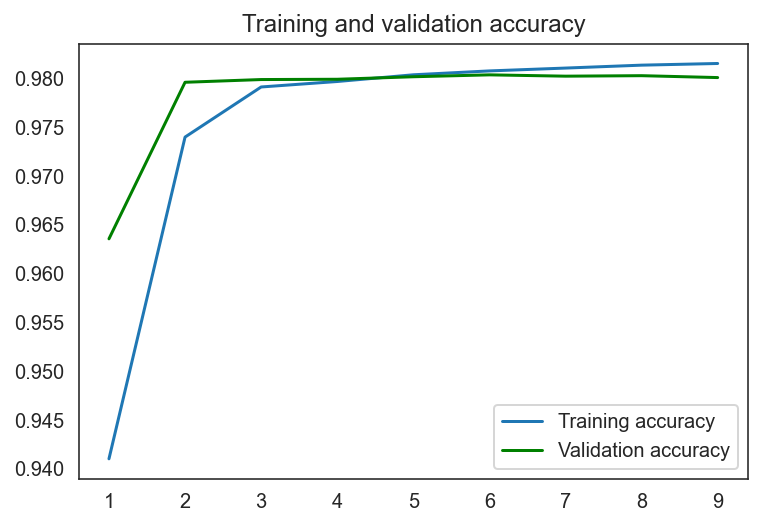

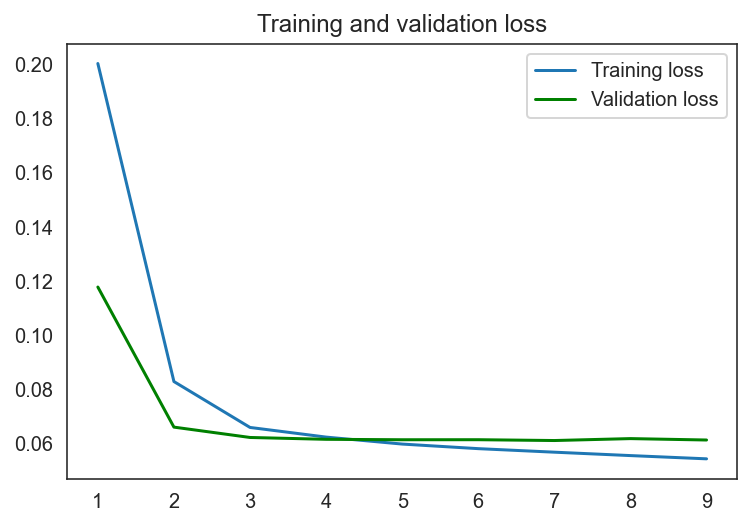

In [166]:
plot_loss_acc(history)

### Training Data Outcomes:

To evaluate the training data, 'taking a look at how the model predictions work on training data 

In [167]:
y_h_train_probs = rnn.predict(X_t)

In [168]:
y_hat_test_proba = rnn.predict(X_te)
y_hat_test_proba[1]

array([0.09348273, 0.00230655, 0.02695137, 0.00548902, 0.03495556,
       0.00861502], dtype=float32)

In [169]:
y_preds = pd.DataFrame(np.round(y_hat_test_proba), columns=target_classes)

In [170]:
y_preds_train = pd.DataFrame(np.round(y_h_train_probs), columns=target_classes)

In [171]:
y_preds

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
39888,0.0,0.0,0.0,0.0,0.0,0.0
39889,0.0,0.0,0.0,0.0,0.0,0.0
39890,0.0,0.0,0.0,0.0,0.0,0.0
39891,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
y_preds.shape

(39893, 6)

In [173]:
y_test.shape

(39893, 6)

In [174]:
val_counts_y_preds = y_preds.apply(pd.Series.value_counts)
val_counts

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,108232,118498,113343,119310,113776,118634
1,11446,1180,6335,368,5902,1044


In [175]:
y_train.shape[1]

6

In [176]:
from sklearn.metrics import classification_report, confusion_matrix

In [177]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

toxic
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    110431
         1.0       0.70      0.87      0.77      9247

    accuracy                           0.96    119678
   macro avg       0.84      0.92      0.88    119678
weighted avg       0.97      0.96      0.96    119678

severe_toxic


C:\Users\aosika\AppData\Local\Continuum\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    119678
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99    119678
   macro avg       0.50      0.50      0.50    119678
weighted avg       1.00      0.99      1.00    119678

obscene
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    113641
         1.0       0.79      0.83      0.81      6037

    accuracy                           0.98    119678
   macro avg       0.89      0.91      0.90    119678
weighted avg       0.98      0.98      0.98    119678

threat
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    119678
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00    119678
   macro avg       0.50      0.50      0.50    119678
weighted avg       1.00      1.00      1.00    119678

insu

### Observations on RNN LSTM_60_50_6

While recall improved in toxic, obscene and insulting classes, severe toxic, threatening and identity -based hate comments continued to remain at zero.
    

In [178]:
for i in range(0,y_train.shape[1]):
    y_i_hat = y_preds.iloc[:,i]
    y_i = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i, y_i_hat))

toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     36045
           1       0.84      0.66      0.74      3848

    accuracy                           0.96     39893
   macro avg       0.90      0.82      0.86     39893
weighted avg       0.95      0.96      0.95     39893

severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39478
           1       0.00      0.00      0.00       415

    accuracy                           0.99     39893
   macro avg       0.49      0.50      0.50     39893
weighted avg       0.98      0.99      0.98     39893

obscene
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37779
           1       0.81      0.75      0.78      2114

    accuracy                           0.98     39893
   macro avg       0.90      0.87      0.88     39893
weighted avg       0.98      0.98      0.98    

In [179]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0


In [180]:
#confusion_matrix(y_i_hat,y_i_t, normalize=False)

In [ ]:
fn.plot_acc_loss(history)

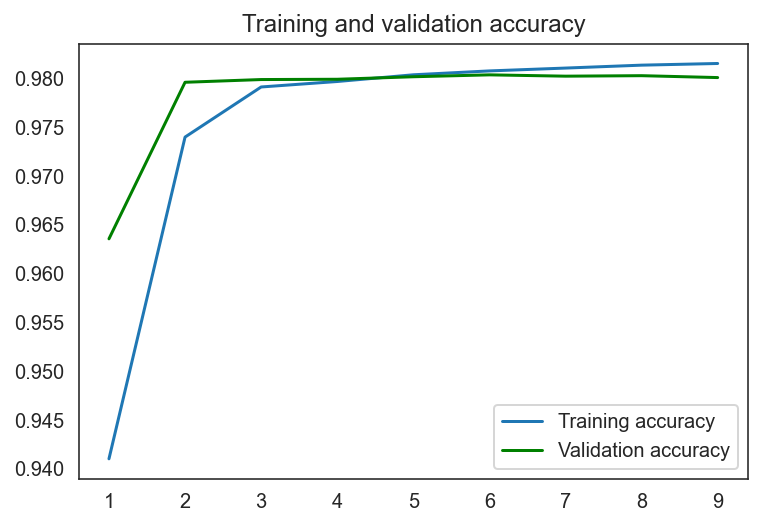

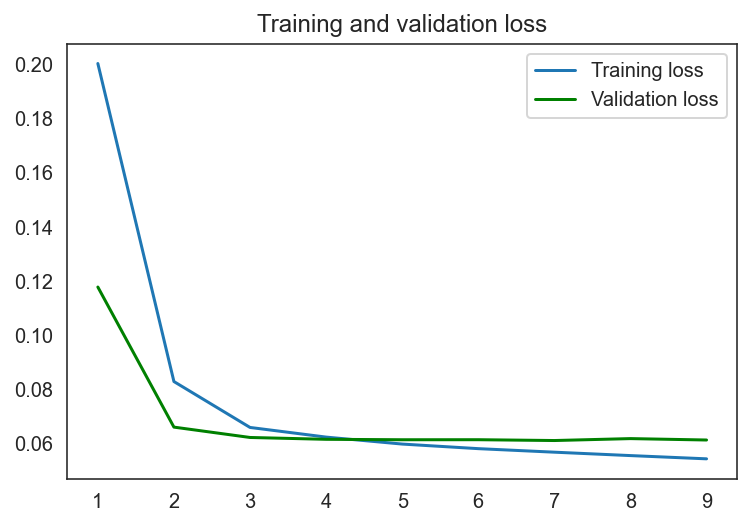

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Attempting to balance the classes to improve predictability using SMOTE

This failed due to multi-label classes.

In [182]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=12, ratio = 1.0)
# x_train_res, y_train_res = sm.fit_sample(X_t,

NameError: name 'X_train_df' is not defined

In [ ]:
# max_features = 2000
# smote_tokenizer = Tokenizer(num_words=max_features)
# smote_tokenizer.fit_on_texts(list(X_train))
# #try texts_to_matrix
# list_tokenized_train_res = tokenizer.texts_to_sequences(x_train_res)
# list_tokenized_test_res = tokenizer.texts_to_sequences(X_test)

In [ ]:
# maxlen = 400
# X_t_sm = pad_sequences(list_tokenized_train_res, maxlen=maxlen)
# X_te_sm = pad_sequences(list_tokenized_test_res, maxlen=maxlen)

Discovered 'Focal_loss' as a means to attempt to offset imbalance.

In [184]:
#!pip install focal-loss
from focal_loss import BinaryFocalLoss


### RNN_LSTM_tiny_10_5_6

In [185]:
rnn_tiny = Sequential()
embedding_size = 128

rnn_tiny.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_tiny.add(LSTM(12, return_sequences=True,name='lstm_layer'))        
rnn_tiny.add(GlobalMaxPool1D())
rnn_tiny.add(Dropout(0.1))  
rnn_tiny.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l1(.0001) ))
rnn_tiny.add(Dropout(0.1))
rnn_tiny.add(Dense(6, activation='sigmoid'))

In [186]:
rnn_tiny.compile(loss=BinaryFocalLoss(gamma=2),
            optimizer='adam',
            metrics=['accuracy'])

In [187]:
## WARNING ⏰ 1 Hour RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_tiny_rnn = rnn_tiny.fit(X_t, y_train, epochs=20, 
                       batch_size=200, 
                       callbacks=early_stopping,
                       validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/18/20 - 06:09 PM
Train on 95742 samples, validate on 23936 samples
Epoch 1/20
95742/95742 [==============================] - 178s 2ms/step - loss: 0.0424 - accuracy: 0.5944 - val_loss: 0.0201 - val_accuracy: 0.9784
Epoch 2/20
95742/95742 [==============================] - 163s 2ms/step - loss: 0.0211 - accuracy: 0.8688 - val_loss: 0.0189 - val_accuracy: 0.9859
Epoch 3/20
95742/95742 [==============================] - 165s 2ms/step - loss: 0.0194 - accuracy: 0.9340 - val_loss: 0.0187 - val_accuracy: 0.9942
Epoch 4/20
95742/95742 [==============================] - 166s 2ms/step - loss: 0.0183 - accuracy: 0.9672 - val_loss: 0.0183 - val_accuracy: 0.9944
Epoch 5/20
95742/95742 [==============================] - 169s 2ms/step - loss: 0.0175 - accuracy: 0.9786 - val_loss: 0.0184 - val_accuracy: 0.9944
Epoch 6/20
95742/95742 [==============================] - 167s 2ms/step - loss: 0.0169 - accuracy: 0.9825 - val_loss: 0.0178 - val_accuracy: 0.9944
Epoch 7/20
95742/95742

In [188]:
# list all data in history
print(history_tiny_rnn.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


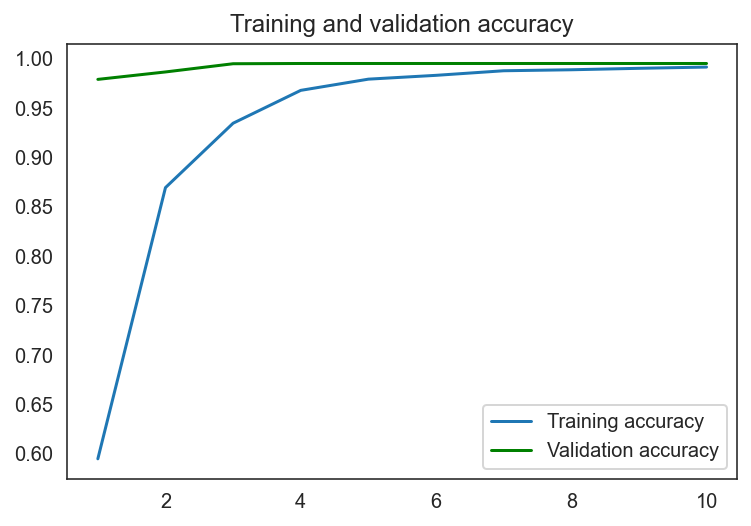

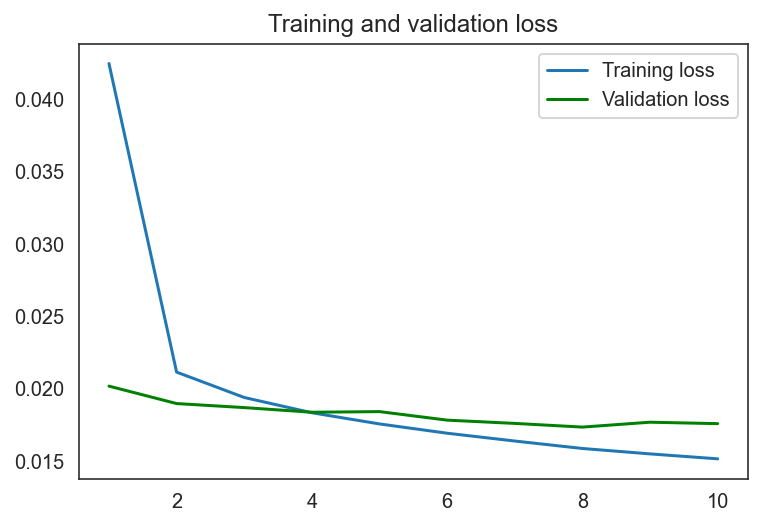

In [189]:
plot_loss_acc(history_tiny_rnn)

In [190]:
y_hat_proba_tiny = rnn_tiny.predict(X_te)

In [191]:
y_preds_tiny = pd.DataFrame(np.round(y_hat_proba_tiny), columns=target_classes)

In [192]:
for i in range(0,y_train.shape[1]):
    y_i_hat_trnn = y_preds_tiny.iloc[:,i]
    y_i_trnn = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(confusion_matrix(y_i_trnn, y_i_hat_trnn, normalize='true'))
    print()
    print(classification_report(y_i_trnn, y_i_hat_trnn))

toxic
[[0.98315994 0.01684006]
 [0.31782744 0.68217256]]

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     36045
           1       0.81      0.68      0.74      3848

    accuracy                           0.95     39893
   macro avg       0.89      0.83      0.86     39893
weighted avg       0.95      0.95      0.95     39893

severe_toxic
[[1. 0.]
 [1. 0.]]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39478
           1       0.00      0.00      0.00       415

    accuracy                           0.99     39893
   macro avg       0.49      0.50      0.50     39893
weighted avg       0.98      0.99      0.98     39893

obscene
[[0.98925329 0.01074671]
 [0.24172185 0.75827815]]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37779
           1       0.80      0.76      0.78      2114

    accuracy                   

### RNN_small_20_10_6

In [193]:
from tensorflow.keras import regularizers

In [194]:
rnn_small = Sequential()
embedding_size = 128

rnn_small.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_small.add(LSTM(20, return_sequences=True,name='lstm_layer'))        
rnn_small.add(GlobalMaxPool1D())
rnn_small.add(Dropout(0.1))  
rnn_small.add(Dense(10, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_small.add(Dropout(0.1))
rnn_small.add(Dense(6, activation='sigmoid'))

In [195]:
                    ##had binary crossentropy
rnn_small.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [196]:
## WARNING ⏰ 30 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_small = rnn_small.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.2)
timer = timer.stop()

[i] Timer started at06/18/20 - 06:37 PM
Train on 95742 samples, validate on 23936 samples
Epoch 1/20
95742/95742 [==============================] - 197s 2ms/step - loss: 0.0684 - accuracy: 0.4532 - val_loss: 0.0200 - val_accuracy: 0.9670
Epoch 2/20
95742/95742 [==============================] - 198s 2ms/step - loss: 0.0210 - accuracy: 0.7261 - val_loss: 0.0181 - val_accuracy: 0.9941
Epoch 3/20
95742/95742 [==============================] - 197s 2ms/step - loss: 0.0182 - accuracy: 0.8575 - val_loss: 0.0179 - val_accuracy: 0.9944
Epoch 4/20
95742/95742 [==============================] - 196s 2ms/step - loss: 0.0171 - accuracy: 0.9128 - val_loss: 0.0171 - val_accuracy: 0.9944
Epoch 5/20
95742/95742 [==============================] - 198s 2ms/step - loss: 0.0164 - accuracy: 0.9319 - val_loss: 0.0171 - val_accuracy: 0.9944
Epoch 6/20
95742/95742 [==============================] - 197s 2ms/step - loss: 0.0159 - accuracy: 0.9482 - val_loss: 0.0169 - val_accuracy: 0.9944
Epoch 7/20
95742/95742

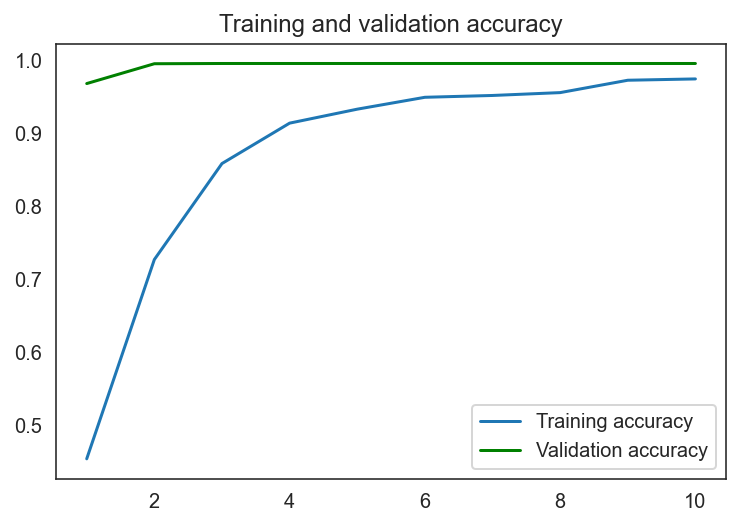

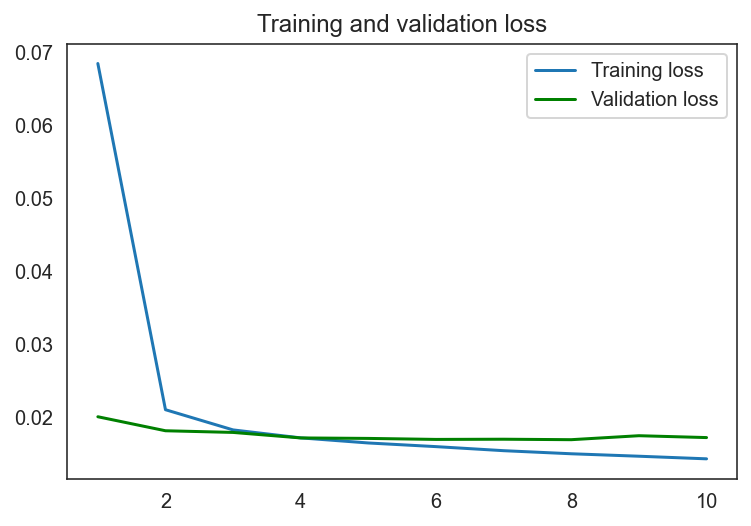

In [197]:
plot_loss_acc(history_small)

In [198]:
from sklearn.metrics import confusion_matrix

In [199]:
y_hat_test_proba_small = rnn_small.predict(X_te)


In [200]:
y_preds_small = pd.DataFrame(np.round(y_hat_test_proba_small), columns=target_classes)

In [201]:
for i in range(0,y_test.shape[1]):
    y_i_hat_sm = y_preds_small.iloc[:,i]
    y_i_t = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(confusion_matrix(y_i_t, y_i_hat_sm,normalize='true'))
    print()
    print(classification_report(y_i_t,y_i_hat_sm))

toxic
[[0.98404772 0.01595228]
 [0.32380457 0.67619543]]

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     36045
           1       0.82      0.68      0.74      3848

    accuracy                           0.95     39893
   macro avg       0.89      0.83      0.86     39893
weighted avg       0.95      0.95      0.95     39893

severe_toxic
[[1. 0.]
 [1. 0.]]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39478
           1       0.00      0.00      0.00       415

    accuracy                           0.99     39893
   macro avg       0.49      0.50      0.50     39893
weighted avg       0.98      0.99      0.98     39893

obscene
[[0.99110617 0.00889383]
 [0.27246925 0.72753075]]

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     37779
           1       0.82      0.73      0.77      2114

    accuracy                   

## Best Model:   LSTM_50_Dense_25_Binary_Focal_Loss

Putting it all together: LSTM_50_Dense_25_Binary_Focal_Loss

https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development.

In [239]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

In [202]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=2), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [203]:
#!pip install focal-loss
from focal_loss import BinaryFocalLoss

In [240]:
rnn_last = Sequential()
embedding_size = 128

rnn_last.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_last.add(LSTM(50, return_sequences=True,name='lstm_layer'))        
rnn_last.add(GlobalMaxPool1D())
rnn_last.add(Dropout(0.2))  
rnn_last.add(Dense(25, kernel_regularizer=regularizers.l2(.00001),activation='relu'))
rnn_last.add(Dense(6, activation='sigmoid'))

In [241]:
rnn_last.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [242]:
## WARNING ⏰ 21 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_lst = rnn_last.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.3)
timer = timer.stop()

[i] Timer started at06/19/20 - 09:29 AM
Train on 83774 samples, validate on 35904 samples
Epoch 1/20
83774/83774 [==============================] - 467s 6ms/step - loss: 0.0435 - accuracy: 0.7965 - val_loss: 0.0205 - val_accuracy: 0.9942
Epoch 2/20
83774/83774 [==============================] - 492s 6ms/step - loss: 0.0193 - accuracy: 0.9928 - val_loss: 0.0178 - val_accuracy: 0.9943
Epoch 3/20
83774/83774 [==============================] - 602s 7ms/step - loss: 0.0171 - accuracy: 0.9942 - val_loss: 0.0166 - val_accuracy: 0.9943
Epoch 4/20
83774/83774 [==============================] - 545s 7ms/step - loss: 0.0162 - accuracy: 0.9943 - val_loss: 0.0165 - val_accuracy: 0.9943
Epoch 5/20
83774/83774 [==============================] - 479s 6ms/step - loss: 0.0157 - accuracy: 0.9944 - val_loss: 0.0165 - val_accuracy: 0.9943
Epoch 6/20
83774/83774 [==============================] - 512s 6ms/step - loss: 0.0150 - accuracy: 0.9944 - val_loss: 0.0166 - val_accuracy: 0.9943
[i] Timer ended at 06/

In [330]:
rnn_last.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         256000    
_________________________________________________________________
lstm_layer (LSTM)            (None, None, 50)          35800     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 156       
Total params: 293,231
Trainable params: 293,231
Non-trainable params: 0
________________________________________________

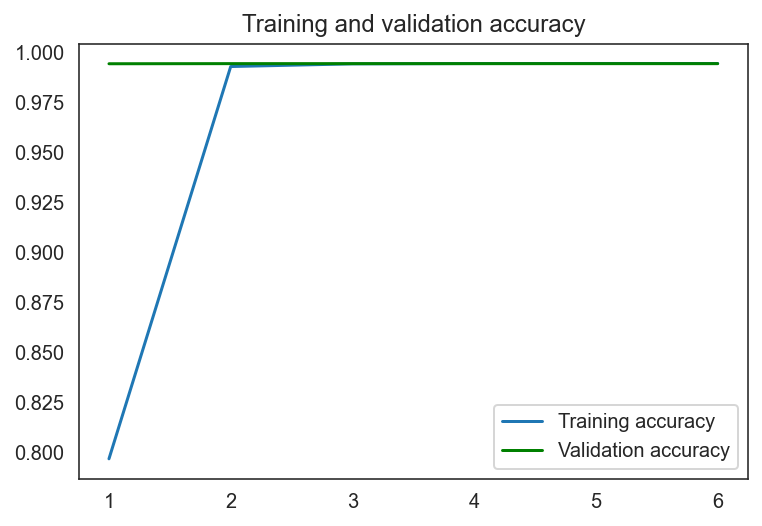

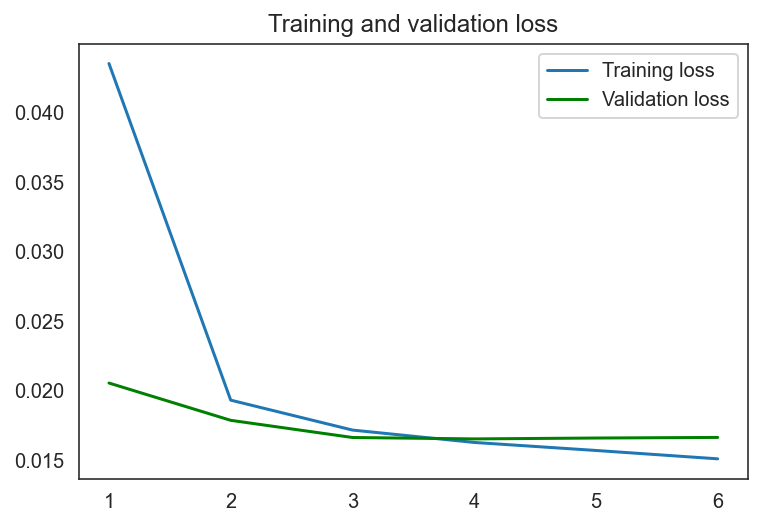

In [249]:
plot_loss_acc(history_lst)

In [250]:
y_hat_test_proba_last = rnn_last.predict(X_te)

In [251]:
y_preds_last = pd.DataFrame(np.round(y_hat_test_proba_last), columns=target_classes)

In [210]:
y_preds_last.shape

(39893, 6)

In [211]:
y_train.shape

(119678, 6)

In [212]:
from sklearn.metrics import classification_report
from sklearn.metrics import auc

In [252]:
for i in range(0,y_train.shape[1]):
    y_i_hat_lst = y_preds_last.iloc[:,i]
    y_i_te = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(confusion_matrix(y_i_te, y_i_hat_lst,normalize='true'))
    print()
    print(classification_report(y_i_te, y_i_hat_lst))
   

toxic
[[0.9853239  0.0146761 ]
 [0.32198545 0.67801455]]

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     36045
           1       0.83      0.68      0.75      3848

    accuracy                           0.96     39893
   macro avg       0.90      0.83      0.86     39893
weighted avg       0.95      0.96      0.95     39893

severe_toxic
[[0.9954405  0.0045595 ]
 [0.61445783 0.38554217]]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39478
           1       0.47      0.39      0.42       415

    accuracy                           0.99     39893
   macro avg       0.73      0.69      0.71     39893
weighted avg       0.99      0.99      0.99     39893

obscene
[[0.98853861 0.01146139]
 [0.22469253 0.77530747]]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37779
           1       0.79      0.78      0.78      2114


### All of the above plus another layer:

In [316]:
rnn_lst_deep = Sequential()
embedding_size = 128

rnn_lst_deep.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_lst_deep.add(LSTM(60, return_sequences=True,name='lstm_layer'))        
rnn_lst_deep.add(GlobalMaxPool1D())
rnn_lst_deep.add(Dropout(0.1))  
rnn_lst_deep.add(Dense(50, kernel_regularizer=regularizers.l2(.00001),activation='relu'))
rnn_lst_deep.add(Dropout(.01))
rnn_lst_deep.add(Dense(10, kernel_regularizer=regularizers.l2(.00001),activation='relu'))
rnn_lst_deep.add(Dense(6, activation='sigmoid'))

In [317]:
rnn_lst_deep.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [318]:
## WARNING ⏰ 21 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_lst_deep = rnn_lst_deep.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.3)
timer = timer.stop()

[i] Timer started at06/22/20 - 05:39 PM
Train on 83774 samples, validate on 35904 samples
Epoch 1/20
83774/83774 [==============================] - 751s 9ms/step - loss: 0.0452 - accuracy: 0.8151 - val_loss: 0.0268 - val_accuracy: 0.9937
Epoch 2/20
83774/83774 [==============================] - 754s 9ms/step - loss: 0.0204 - accuracy: 0.9839 - val_loss: 0.0176 - val_accuracy: 0.9813
Epoch 3/20
83774/83774 [==============================] - 814s 10ms/step - loss: 0.0169 - accuracy: 0.9786 - val_loss: 0.0168 - val_accuracy: 0.9812
Epoch 4/20
83774/83774 [==============================] - 772s 9ms/step - loss: 0.0161 - accuracy: 0.9817 - val_loss: 0.0169 - val_accuracy: 0.9923
Epoch 5/20
83774/83774 [==============================] - 693s 8ms/step - loss: 0.0156 - accuracy: 0.9901 - val_loss: 0.0171 - val_accuracy: 0.9940
[i] Timer ended at 06/22/20 - 06:42 PM
- Total time = 1:03:05.894421


In [319]:
y_hat_test_proba_lst_deep = rnn_lst_deep.predict(X_te)
y_preds_lst_deep = pd.DataFrame(np.round(y_hat_test_proba_lst_deep), columns=target_classes)

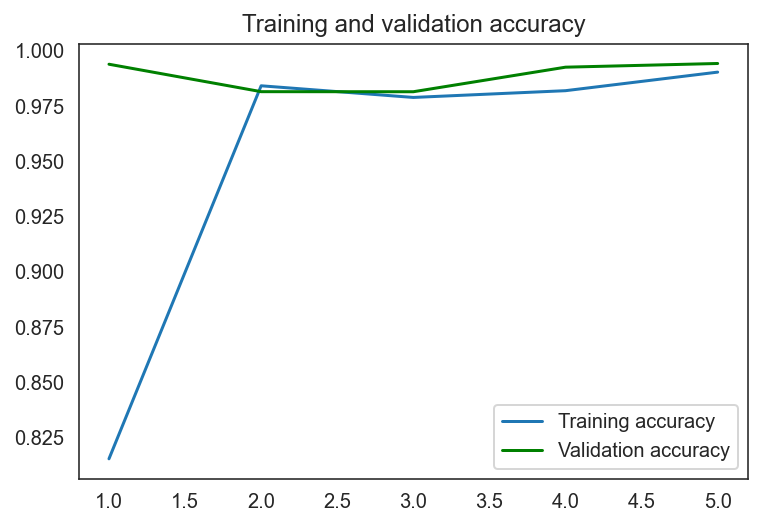

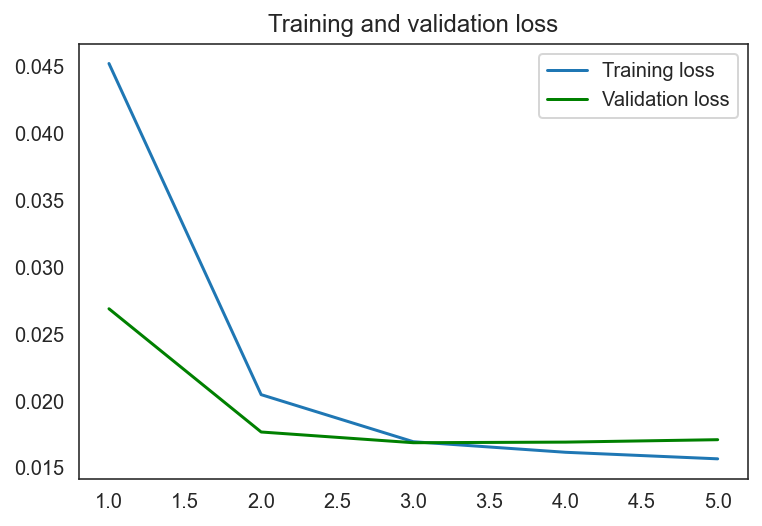

In [320]:
plot_loss_acc(history_lst_deep)

In [321]:
for i in range(0,y_train.shape[1]):
    y_i_hat_lst_deep = y_preds_lst_deep.iloc[:,i]
    y_i_te = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(confusion_matrix(y_i_te, y_i_hat_lst,normalize='true'))
    print()
    print(classification_report(y_i_te, y_i_hat_lst_deep))

toxic
[[1. 0.]
 [1. 0.]]

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     36045
           1       0.89      0.62      0.73      3848

    accuracy                           0.96     39893
   macro avg       0.93      0.81      0.85     39893
weighted avg       0.95      0.96      0.95     39893

severe_toxic
[[1. 0.]
 [1. 0.]]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39478
           1       0.75      0.01      0.01       415

    accuracy                           0.99     39893
   macro avg       0.87      0.50      0.50     39893
weighted avg       0.99      0.99      0.98     39893

obscene
[[1. 0.]
 [1. 0.]]

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     37779
           1       0.88      0.67      0.76      2114

    accuracy                           0.98     39893
   macro avg       0.93      0.83      0.

## Conclusion:

In [214]:
#https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
#https://gombru.github.io/2018/05/23/cross_entropy_loss/
#https://pypi.org/project/focal-loss/#:~:text=TensorFlow%20implementation%20of%20focal%20loss%20%5B1%5D%3A%20a%20loss%20function,losses%20functions%20and%20classes%2C%20respectively.

In [322]:
val_counts

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,108232,118498,113343,119310,113776,118634
1,11446,1180,6335,368,5902,1044


The *goal* of this prjoect was to use NLP analysis to build a multi-headed model capable of detecting different types of online discussion toxicity like threats, obscenity, insults, and identity-based hate.

Since I had little experience with deep learning, that was the method used to classify to gain experience.  It proved to be a challenging problem.

There was signficant target imbalance of 10% being amplified needing to categorize 6 overlapping classes.  A search indicates that that this problem exists even for experts in the field.  One example can be found here where [researchers at Stanford](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/reports/6837517.pdf) experimented with this problem and still  seek ways to overcome this challenge.  



**Preprocessing:** 

In evaluating the toxic text/comments to identify what classified them as such, patterns developed that demonstrated specific words helped in identifying toxicity. In particular, the same three words appared between 75%-100% of the time in four of the categories: Toxic, Severe Toxic, Insulting, and Obscene.  More unique words were used in threatening comments and identity-based hate comments.  Comment length was also comparitvely evaluated. It was determined that there was little difference in comment lenght between those made with toxic sentiment and those without. 

Also it was observed that there was major imbalance in the classes severe toxic, threat, and identitiy hate.  The table below illustrates this.  If a row has a 0 it indicates no target was identified.  A row with a 1 indicates a target was identified:

| Target | Toxic |Severe_Toxic| Obscene	| Threat|	Insult |	Identity_Hate |
|--| ---   | ---        | ---      | ---   | ---      | ---              |    
| 0	|108,232	|118,498|	113,343	|119,310	|113,776	|118,634 |
|1	|1,1446	|1,180	|6335	|368| 5902	|1044|

Several Neural Netowrks were modeled using Keras: https://keras.io/

While varying deep learning models were able to have high rates of accuracy their ability to identify toxic text proved to be more simple than the case of identifying the extremely underclassified examples, with an accuracy of rate of 96% , recall topped out at ~87% in the best case in the multi-class model using deep learning for one category.  In most cases, recall was 0 for the smaller classes.  

**An initial and very shallow model was used as a baseline with extremely poor outcomes.** This model had a dense input layer of 10 and output of 6 to map to the varying classifiers. Using 'relu' activator on the main layer, and sigmoid on the exit, along with binary cross entropy as a loss function and stochastic gradient descent or sdg as the  optimizer.  
Despite having an accuracy rate of 90% recall in all cases was 0 for being able to classify a true postive - or effectively classify anything.

Since accuracy was high but the model seemed to not be able to identify true positives accuarately the *key metric identified to evaluate the model would be recall - specifically around True Positives*

A Recurrent Neural Network was implemented using an embedding layer of 128 and LSTM Long Short Term Memory and dropout to see if improvement could be made.  In addition a l2 regulizer was added with a lambda of .0001.  This LSTM input layer with 60 neurons was followed by a MaxPool1 D layer and a dropout rate of 10% followed subsequently.  This model added a hidden layer and dropped the neurons in the hidden layer to 20, followed by an additional layer of 10% dropout. The output layer was the same as the first model with sigmoid activation.  However this time an 'adam' optimizer replaced the 'sdg'.  In this case, recall improved in the case of toxic (.87), obscene(.83), and insults(.75) classification. However in the cases of severe toxic, threatening and identity-based hate comments, all recall was zero.  One could attribute this to extreme class-imbalance.  

**3 - Layer RNN with a pattern 60_50_6 : Recall for all True Negatives was .98 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | **.87**
|Severe Toxic | .0
|Obscene | **.83**
|Threatening | .0
|Insult | **.75**
|Identity Hate | .0 


Focal loss was implemented on varying sized neural networks with the same number of layers with similar outcomes.

**3 - Layer RNN with a pattern 10_5_6 : Recall for all True Negatives was .99 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | .68
|Severe Toxic | .0
|Obscene | .76
|Threatening | .0
|Insult | .66
|Identity Hate | .0 


**3 - Layer RNN with a pattern 20_10_6 : Recall for all True Negatives was .99 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | .68
|Severe Toxic | .0
|Obscene | .73
|Threatening | .0
|Insult | .59
|Identity Hate | .0 

**3 - Layer RNN with a pattern 50_25_6 : Recall for all True Negatives was .99 - 1.0**

|Classification | Recall|
|-- | --|
|Toxic | .68
|Severe Toxic | **.39**
|Obscene | .78
|Threatening | .0
|Insult | .65
|Identity Hate | .0 


Despite having an overall lower recall this model is considered the best model because it was able to predict Severe Toxic comments 39% of the time which is better than any other model.  




## Reommendations:

It's recommended to use this model to find overall toxic language and develop metrics and associated action plans to mitigate the use of toxic language.  It provides a foundation for future work on this subject matter.

## Future work:

Future work could be done in building out this model as well as modeling the more severe types of toxic comments - especially threats, as well as diving perhaps in to sentence structures to capture sentiment.

Thankfully the most severe types of toxic comments are less frequent.  Despite the occurance of these severe cases, threats are serious.  In some situations, speech can constitute a crime, such as in the case of criminal threats. A criminal threat, sometimes known as the terrorist threat, malicious harassment, or by other terms, occurs when someone threatens to kill or physically harm someone else with intent and specificity.  https://www.fbi.gov/audio-repository/news-podcasts-gotcha-prison-time-for-making-threats-over-the-internet-ii.mp3/view. It's recommended to collect more data around these more severe types of toxic comments to improve recognition. 

Perhaps modeling could be done to classify three main categories: Toxic- which would encapsulate toxic, severely toxic, insulting and obscene; Threatening and Identity - they could be single category classifiers. 

As mentioned before, the most obvious toxic words are fairly easy to classify.  However sometimes when looking closely at single words, sentiment is lost in adjacent text.  A comparative analysis could also be conducted by tokenizing phrases see if additional insight could be collected.


## Appendix:

### Clean Word Cloud

In [216]:
#! pip install wordcloud
import matplotlib.pyplot as plt

(-0.5, 399.5, 199.5, -0.5)

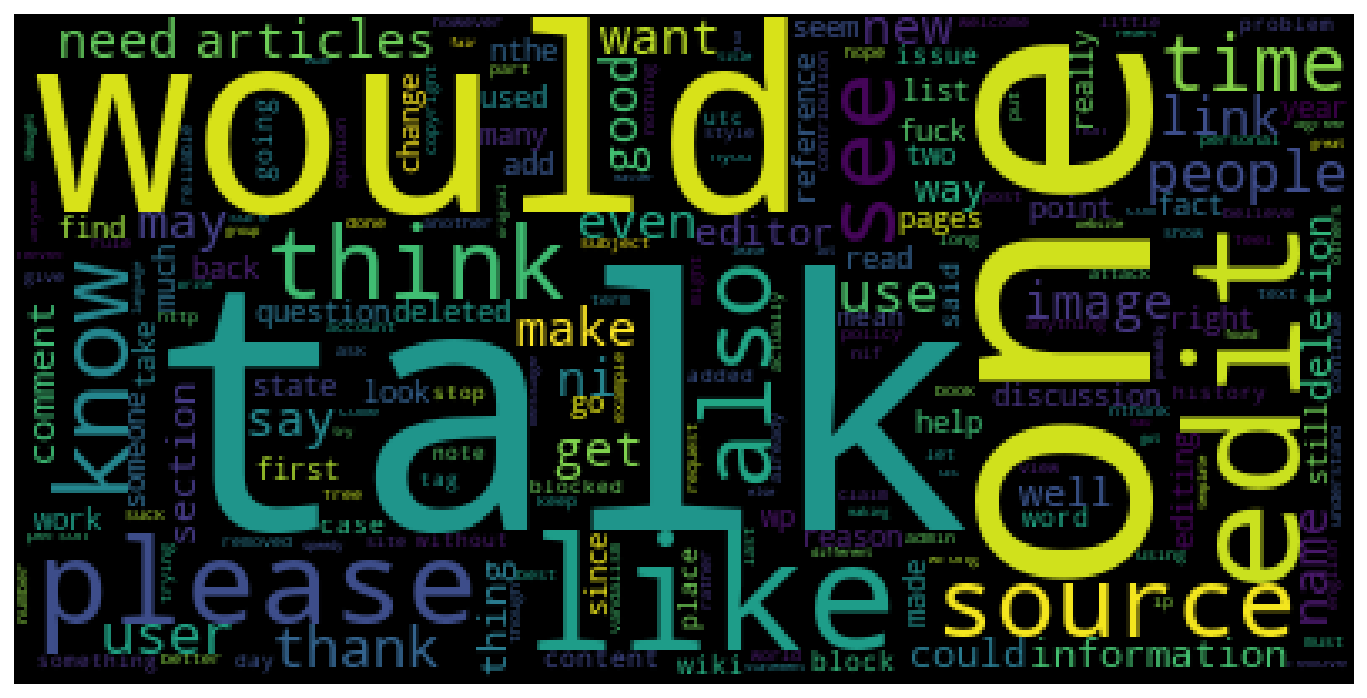

In [217]:
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [218]:
print("toxic:")
print(train[train['toxic']==1].iloc[2,1])

toxic:
Bye! 

Don't look, come or think of comming back! Tosser.


In [219]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [220]:
print("Example of severe toxic text:")
print('\n')
print(train[train['severe_toxic']==1].iloc[4,1])

Example of severe toxic text:


What a motherfucking piece of crap those fuckheads for blocking us!


In [221]:
print("Example of obscene text:")
print('\n')
print(train[train['obscene']==1].iloc[4,1])

Example of obscene text:


Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!


In [222]:
X_train.head()

143075    Please do not add unsourced or original conten...
65320     This page needs a new update of the UMW seal. ...
64545     "\n\nOh, so sad! Why you always remind of me? ...
58827     Brother==\nWhy isn't his brother David mention...
6536      Biographies\nHello Sparky331, and welcome to W...
Name: comment_text, dtype: object

In [223]:
X_train

143075    Please do not add unsourced or original conten...
65320     This page needs a new update of the UMW seal. ...
64545     "\n\nOh, so sad! Why you always remind of me? ...
58827     Brother==\nWhy isn't his brother David mention...
6536      Biographies\nHello Sparky331, and welcome to W...
                                ...                        
97639     ACTUAL RESEARCH INTO THE POSSIBILITY OF A CHAR...
95939     He insulted me first. To be fair, you should w...
152315    That page needed to go away. Good riddance.  [...
117952    Useful template \n\n for the very many USAcent...
43567     "\n\nBritish Empire\n""The British Empire appe...
Name: comment_text, Length: 119678, dtype: object

### Cleaning up the most offensive words in the generalized toxic word cloud:

The nature of this project brings with it finding uber-offensive text.  For the sake of displaying these terms in  a way to convey sentiment without being overtly offensive, I'm editing some of the most brash.

In [224]:
## creating a dictionary of the most offensive words
replace = {'fuck': 'f$%!', 'nigger' : 'n*$$#@' ,'nigga':'n#5#*', 'fucking' : 'f*@%!ng',
           'faggot':'f@&&*#', 'cunt' : 'c&#^' , 'fag' : 'f@$',
           "'fuck" : "'f$%!'", 'faggots':'f@&&*!$'}

#using the 'replace' dictionary above, 

new_dict = {}
for k, v in dict(freq_tox).items():
    if k in replace:
        key = replace[k]
    else:
        key = k
        
    new_dict[key] = v
    
    

In [225]:
new_dict

{'f$%!': 8316,
 'like': 3458,
 'shit': 3282,
 'n*$$#@': 3243,
 'suck': 3136,
 'f*@%!ng': 3118,
 'ass': 2856,
 'hate': 2600,
 'u': 2587,
 'go': 2546,
 'know': 2177,
 'get': 2147,
 'gay': 2070,
 'fat': 1953,
 'f@&&*#': 1908,
 'die': 1870,
 'moron': 1843,
 'people': 1808,
 'bitch': 1668,
 'hi': 1544,
 'one': 1440,
 'c&#^': 1435,
 'stupid': 1383,
 'pig': 1344,
 'jew': 1327,
 'talk': 1319,
 'think': 1224,
 'want': 1208,
 'sucks': 1194,
 'stop': 1149,
 'wiki': 1132,
 'dick': 1098,
 'would': 1080,
 'block': 1049,
 'wanker': 1019,
 'time': 1007,
 'life': 1005,
 'bark': 1000,
 'even': 992,
 'balls': 987,
 'f@$': 986,
 'dont': 974,
 'going': 946,
 'sex': 928,
 'make': 923,
 'cock': 906,
 'edit': 898,
 'vandalism': 898,
 'right': 897,
 'see': 872,
 'little': 842,
 'piece': 841,
 'user': 822,
 'nipple': 822,
 'asshole': 804,
 'really': 797,
 'penis': 797,
 'kill': 788,
 'aids': 779,
 'hell': 767,
 'dickhead': 750,
 'good': 749,
 "'f$%!'": 732,
 'fucker': 730,
 'care': 727,
 'say': 725,
 'bastard':

In [226]:
edited_toxic_text = list(new_dict.items())



In [227]:
edited_toxic_text = str(edited_toxic_text)

In [228]:
timer = fn.Timer()

timer.start()
edited_toxic_tokens = word_tokenize(edited_toxic_text)
timer.stop()

[i] Timer started at06/18/20 - 08:07 PM
[i] Timer ended at 06/18/20 - 08:07 PM
- Total time = 0:00:00.006983


(-0.5, 399.5, 199.5, -0.5)

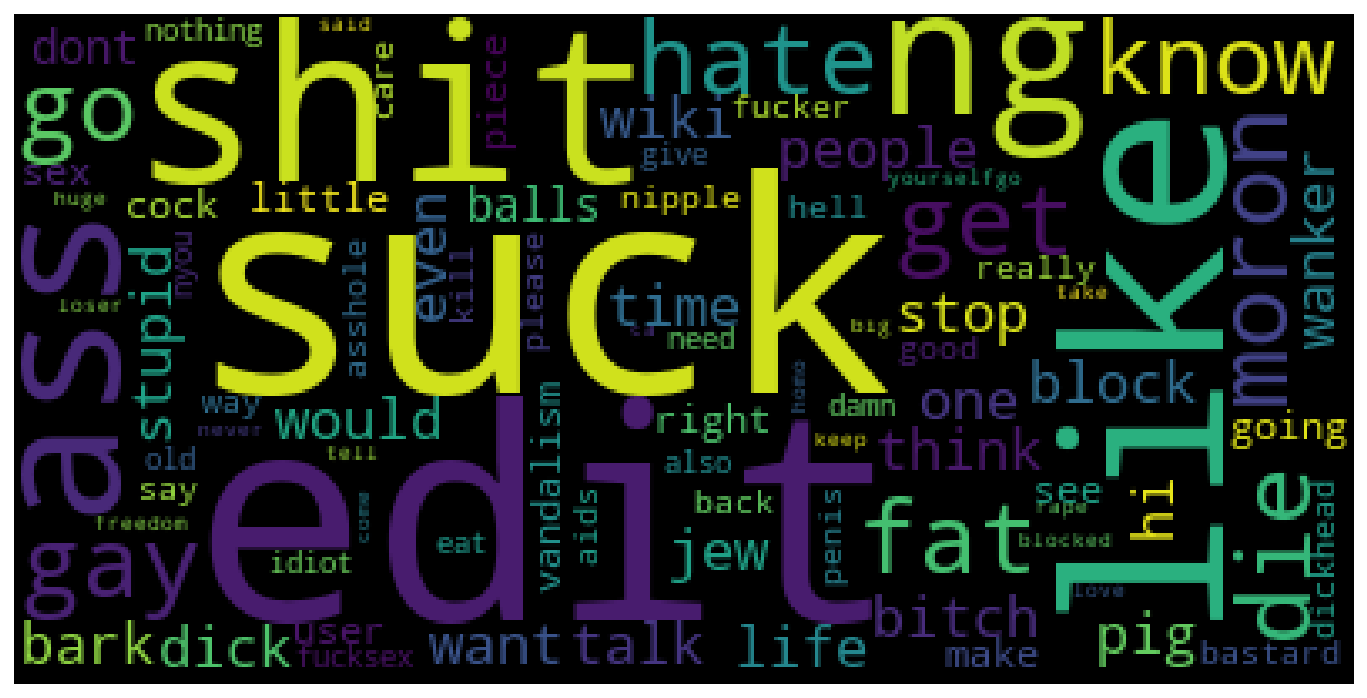

In [229]:
wordcloud_tox_clean = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud_tox_clean.generate(','.join(edited_toxic_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud_tox_clean) 
plt.axis('off')

In [230]:
def highlight_max(x):
    return ['background-color: yellow' if v == x.max() else ''
            for v in x]

In [231]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, 
# toxic is most frequent by far and 
main_col="toxic"
corr_mats=[]
for other_col in y_train.columns:
    confusion_mat = pd.crosstab(y_train[main_col], y_train[other_col])
    corr_mats.append(confusion_mat)
out = pd.concat(corr_mats,axis=1,keys=y_train)

#cell highlighting
out = out.style.apply(highlight_max,axis=0)
out

In [232]:
#squeaky clean

#marking comments without any tags as "clean"
rowsums=y_train.sum(axis=1)
train['clean']=(rowsums==0)
train['toxic']=(rowsums!=0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",train['clean'].sum()+train['toxic'].sum())
print("Total clean comments = ",train['clean'].sum())
print("Total toxic comments = ",train['toxic'].sum())

Total comments =  119678
Total clean comments =  107557
Total toxic comments =  12121


In [233]:
timer = fn.Timer()
timer.start()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(X_train)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(fn.process_comment.(iloc[:train.shape[0]]))
timer.stop()


SyntaxError: invalid syntax (<ipython-input-233-bc7feb2b81fa>, line 10)

In [ ]:
df.head()

In [ ]:
#https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
#https://gombru.github.io/2018/05/23/cross_entropy_loss/
#https://pypi.org/project/focal-loss/#:~:text=TensorFlow%20implementation%20of%20focal%20loss%20%5B1%5D%3A%20a%20loss%20function,losses%20functions%20and%20classes%2C%20respectively.

## Binomal classification: 

In [258]:
Xdf = df['comment_text']
ydf = df['threat']

In [259]:
Xdf_train, Xdf_test, ydf_train, ydf_test = train_test_split(Xdf, ydf)

In [260]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(Xdf_train))
#try texts_to_matrix
list_tokenized_traindf = tokenizer.texts_to_sequences(Xdf_train)
list_tokenized_testdf = tokenizer.texts_to_sequences(Xdf_test)

In [261]:
dfcomments = [len(comment) for comment in list_tokenized_traindf]

In [262]:
maxlen = 400
X_t_df = pad_sequences(list_tokenized_traindf, maxlen=maxlen)
X_te_df = pad_sequences(list_tokenized_testdf, maxlen=maxlen)

In [263]:
rnn_smalldf = Sequential()
embedding_size = 1100

rnn_smalldf.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_smalldf.add(LSTM(20, return_sequences=True,name='lstm_layer'))        
rnn_smalldf.add(GlobalMaxPool1D())
rnn_smalldf.add(Dropout(0.1))  
rnn_smalldf.add(Dense(10, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_smalldf.add(Dropout(0.1))
rnn_smalldf.add(Dense(2, activation='sigmoid'))

In [264]:
rnn_smalldf.compile(loss=BinaryFocalLoss(gamma=2),
                  optimizer='adam',
                  metrics=['accuracy'])

In [265]:
## WARNING ⏰ 21 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_smalldf = rnn_smalldf.fit(X_t_df, ydf_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.3)
timer = timer.stop()

[i] Timer started at06/21/20 - 01:11 PM
Train on 83774 samples, validate on 35904 samples
Epoch 1/20
83774/83774 [==============================] - 1219s 15ms/step - loss: 0.0159 - accuracy: 0.2345 - val_loss: 0.0067 - val_accuracy: 0.0141
Epoch 2/20
83774/83774 [==============================] - 1284s 15ms/step - loss: 0.0052 - accuracy: 0.3326 - val_loss: 0.0037 - val_accuracy: 0.0192
Epoch 3/20
83774/83774 [==============================] - 1266s 15ms/step - loss: 0.0034 - accuracy: 0.3349 - val_loss: 0.0039 - val_accuracy: 0.0221
Epoch 4/20
83774/83774 [==============================] - 2017s 24ms/step - loss: 0.0025 - accuracy: 0.2997 - val_loss: 0.0042 - val_accuracy: 0.0326
[i] Timer ended at 06/21/20 - 02:47 PM
- Total time = 1:36:26.865268


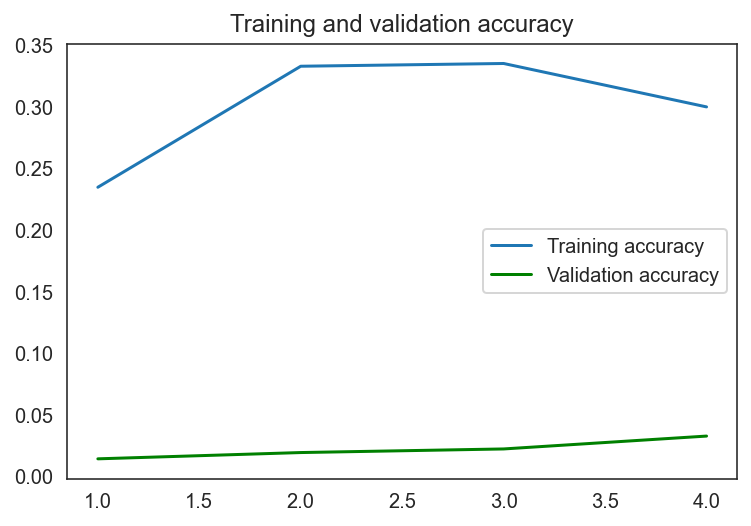

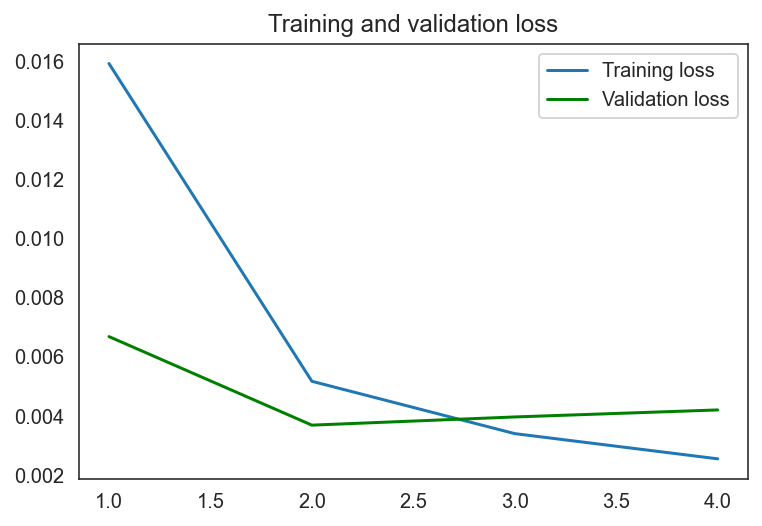

In [324]:
plot_loss_acc(history_smalldf)

In [326]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,toxic_text,wrd_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,False,42
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True,False,18
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True,False,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True,False,112
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True,False,13


In [327]:
target_class = ['comment_text', 'threat']

In [323]:
y_hat_test_proba_rnn_smalldf = rnn_smalldf.predict(X_te_df)

In [328]:
y_preds_rnn_smalldf = pd.DataFrame(np.round(y_hat_test_proba_rnn_smalldf), columns=target_class)

In [329]:
fn.class_report_model(ydf_train, ydf_test, y_preds_rnn_smalldf)

IndexError: tuple index out of range

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])